# Credit Card Service Prediction Model

# Load Libraries

In [1]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import scipy.stats as stats 

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# to make this notebook's output identical at every run
np.random.seed(42)

# Function Definitions

In [2]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2 )
    return df

def draw_col_shape(df_feature,cols):
    # draw a bar graph with he number of members of a columns specify in field Cols
    
    # Dictionary for X Axis Labels
    dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
                 'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
                 'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
                 'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
                 'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
                 'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
                 'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 'aaa_mortgage':'Used Mortgage Service',
                  'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service','aaa_travel':'Travel Services',
                 'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
                 'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',
                 'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service', 'aaa_cancel':'Cancelled (Y/N)',
                 'use_road_side':'Use Roadside'
                }


    # number of members per state

    for col in cols:
        counts = df_feature[col].value_counts()
        sns.set(style="whitegrid")
        plt.axhline(0, color="k", clip_on=False)
        plt.ylabel("# of Classes",fontsize=14, fontweight='bold')
        plt.xlabel("Classes", fontsize=14, fontweight='bold')
        plt.title('Total  Number of Classes',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        sns.barplot(counts.index, counts.values)
        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large')
        i = 0
        for v in list(counts.values):
            plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
            i +=1
        plt.show()
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        counts.reset_index(inplace=True)
        counts.rename(columns={"index": dict_cols[col], col: "# of Classes"}, inplace=True)
        fig = ff.create_table(counts, height_constant=30, index=False)
        py.iplot(fig)
        return

def cross_entropy(predictions, targets, epsilon=1e-10):
    # To calculate the cross Entropy Loss to validate model performance
    # Cross Entropy Loss
        # Cross-entropy loss, or log loss, measures the performance of a classification model 
        # whose output is a probability value between 0 and 1. #
        # Cross-entropy loss increases as the predicted probability diverges from the actual label. 
        # So predicting a probability of .012 when the actual observation label is 1 would be bad and 
        # result in a high loss value. # A perfect model would have a log loss of 0.
        
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
    return ce_loss

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan
    

# Load data from consolidate file by household key and transacton file 

In [3]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_household = read_data('household_view.csv')
df_transaction = read_data('capstone_aaa_featured.csv')
df_original_house_hold = df_household.copy()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

var_to_predict = ['aaa_credit_card']
var_to_predict_title = 'Credit Card Services'
var_to_predict_save = 'credit'
# create feature Cancel = 1 - member cancelled, if 0 active member
df_household['aaa_cancel'] = 1
df_household['aaa_cancel']=np.where(df_household['member_status']== 'ACTIVE', 0, 
                                    df_household['aaa_cancel'])
df_household['aaa_cancel']=np.where(df_household['member_status']== 'PENDING', 0, 
                                    df_household['aaa_cancel'])
df_household['aaa_cancel']=np.where(df_household['member_status']== 'CANCELLED', 1, 
                                    df_household['aaa_cancel'])
# Create roadside usage
df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))

df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                    df_household.consumer_score)

df_household.consumer_score = np.where(~(df_household.consumer_score > 0), df_household.consumer_score.mean(), 
                                           df_household.consumer_score)

In [4]:
df_household.groupby(by=var_to_predict).mean()

membership_id  household_key       zip  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  length_of_residence  aaa_mortgage  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_travel  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  aaa_no_kcl_b_ind_mosaicsgrouping  aaa_no_occupation_code  aaa_no_occupation_group  aaa_no_occupant_type  aaa_no_plus_indicator_description  aaa_no_generation  total_calls_year_1  total_calls_year_2  total_calls_year_3  total_member_cost_1  total_member_cost_2  total_member_cost_3  basic_cost  plus_cost  premier_cost  mean_basic_cost  mean_plus_cost  mean_premier_cost  total_calls  total_member_cost  mean_total_member_cost  total_tow_miles  \
aaa_credit_card                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
0                  127287.4414  14917252.6693 3111.6915         1.2903                  46.5490       75.0220               5.7623        0.0643       0.0049           0.0011                 0.0643              0.2626        0.0404                    0.5530      0.1237          1.7138              22.0259       2.7385             0.1185            1.9678         5.1704                0.4210                2.5156         1.5939           0.1682                2.7083             3.9167                  10.8976                          3.1516                            5.0228                  7.4660                   5.6411                1.3292                             0.9642             0.9934              1.5868              2.9092              2.9417              86.4048             158.7278             152.3550    109.4678     9.1747        0.0205          20.2821          1.4826             0.0066       7.4377           397.4876                 54.3972           6.1087   
1                  113091.1017  14028161.8379 2901.4690         1.2638                  47.9879       71.9695               7.8408        0.1155       0.0086           0.0017                 0.1155              0.3724        0.0793                    0.5463      0.2638          1.7348              26.5159       3.0738             0.0615            2.0000         4.5927                0.3091                2.5449         1.6000           0.2640                2.8500             4.2943                   9.6128                          2.8783                            4.5973                  6.2059                   6.3949                1.1842                             1.0153             1.2157              2.1017              3.4379              3.8517             109.6136             184.3628             194.0360    141.3932     8.9190        0.0000          25.1255          1.2298             0.0000       9.3914           488.0123                 61.6654           7.5547   

                 mean_tow_miles  total_cost 

In [5]:
df_transaction.groupby(by=['membership_id','fsv_credit_card_flag']).mean()

individual_key  household_key  member_flag      zip5          zip9  fsv_cmsi_flag  fsv_deposit_program_flag  fsv_home_equity_flag  fsv_id_theft_flag  fsv_mortgage_flag  ins_client_flag  trv_globalware_flag  length_of_residence  do_not_direct_mail_solicit  email_available  ers_ent_count_year_1  ers_ent_count_year_2  ers_ent_count_year_3  ers_member_cost_year_1  ers_member_cost_year_2  ers_member_cost_year_3  right_individual_key    member_key  member_number_associate_id  member_tenure_years  months_from_join_to_cancel       zip  new_mover_flag  basic_cost  calculated_tow_miles  call_canceled  call_killed  cash_call  fleet_indicator  is_duplicate  is_nsr  member_match_flag  member_number_and_associate_id  motorcycle_indicator  plus_cost  premier_cost        rec_id  total_cost  tow_destination_latitude  tow_destination_longitude  was_duplicated  was_towed_to_aar_referral  no_child  no_race  no_home_owner  no_education  no_income  no_dwelling_type  \
membership_id fsv_credit_card_flag                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
153           1                      52211550.0000   4500791.0000       1.0000 2893.0000 28933850.0000         0.0000                    0.0000                0.0000             0.0000             0.0000           0.0000               0.0000              15.0000                      0.0000           0.0000                0.0000                0.0000                2.0000                  0.0000                  0.0000                 65.0000         52211550.0000  1500014.0000                  15300.0000              49.0000                      0.0000 2893.0000          0.0000     33.8333                0.0889         0.0000       0.0000     0.1111           0.1111        0.0000  0.1111             1.0000                      15300.0000                0.0000     0.0000        0.0000  6563853.6667     33.8333                    4.5556                    -7.8889          0.0000                     0.1111    2.0000   2.0000         0.0000        1.0000     8.0000            2.0000   
155           0                       1606764.0000   4317516.0000       1.0000 2878.0000 28781026.0000         0.0000                    0.0000                0.0000             0.0000             0.0000           0.0000               0.0000               0.0000                      0.0000           0.0000                0.0000                0.0000                0.0000                  0.0000                  0.0000                  0.0000          1606764.0000  1500016.0000                  15500.0000              13.0000                     85.0000 2878.0000          0.0000      0.0000                0.0000            nan          nan        nan              nan        0.0000  0.0000             0.0000                          0.0000                   nan     0.0000        0.0000        0.0000      0.0000                       nan                        nan          0.0000                     0.0000       nan      nan            nan           nan        nan            0.0000   
163           0                       2766867.77

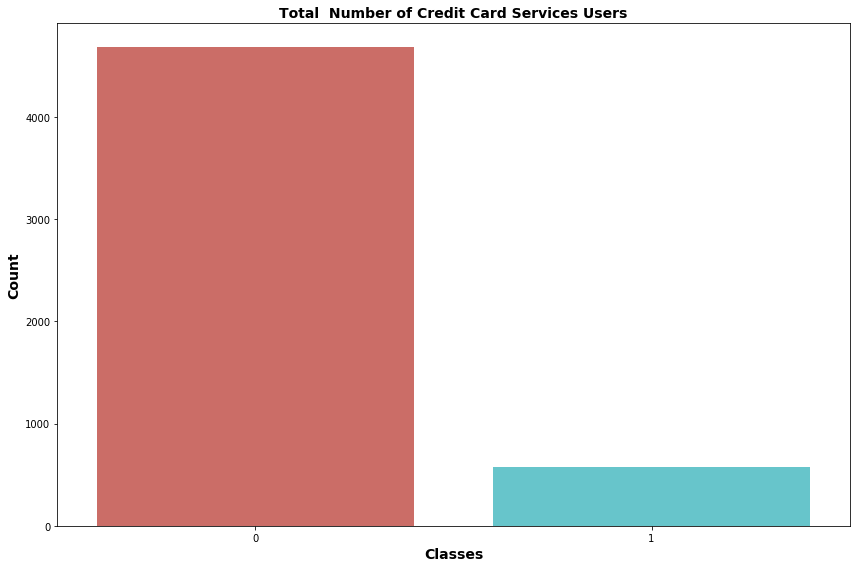

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(x=var_to_predict[0],data=df_household, palette='hls')
plt.title('Total  Number of '+var_to_predict_title + ' Users',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.ylabel("Count",fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=14, fontweight='bold')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_count_plot')
plt.show()

In [7]:
# Number of members in household key
df_household.total_members_in_household.value_counts()

2     1907
1     1523
3      932
4      529
5      234
6       73
7       42
8        9
9        7
10       4
15       1
Name: total_members_in_household, dtype: int64

In [8]:
# graph income
pd.crosstab(df_household.total_members_in_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title + ' Frequency for Total # of Members within Househould')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'members_hh_use_'+var_to_predict_save)
plt.show()

# Outcomes
The frequency of credit card use depend heavily on the number of members within a household.
Will consolidate income in five categories: 
    * a) 1 member within a household 
    * b) 2 members within a household
    * c) 3 members within a household
    * b) 4 members within a household
    * c) +5 members within a household 

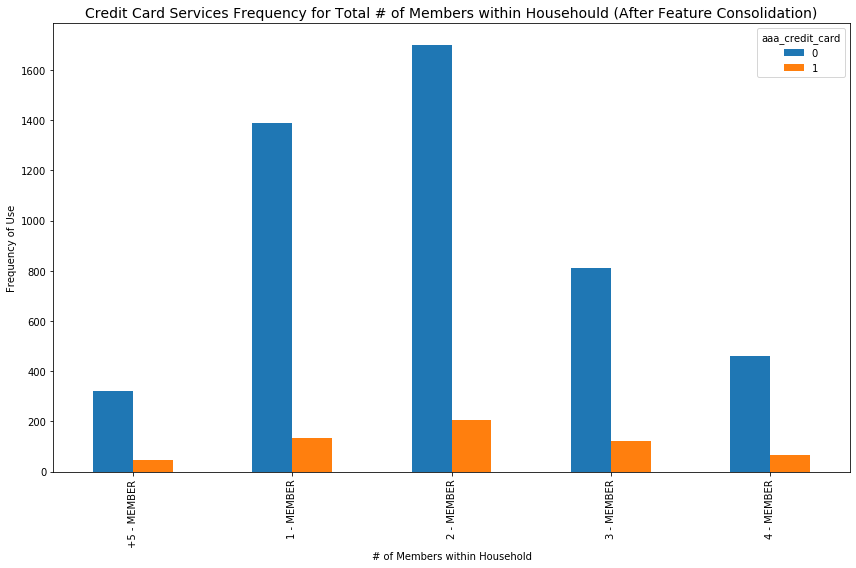

In [9]:
# Number of members

df_household['no_members'] = ' '
df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                    df_household['no_members'])

df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                    df_household['no_members'])
group5 = np.arange(5,20,1)
for i in group5:
    df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                    df_household['no_members'])
    
pd.crosstab(df_household.no_members,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Total # of Members within Househould (After Feature Consolidation)')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'members_hh_'+var_to_predict_save+'_feat')
plt.show()

In [10]:
# Graph travel Services
df_household.aaa_travel.value_counts()

0    4529
1     732
Name: aaa_travel, dtype: int64

In [11]:
# graph income
pd.crosstab(df_household.aaa_travel,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title + '- Frequency for Travel Services')
plt.xlabel('Travel')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'travel_use_'+var_to_predict_save)
plt.show()

In [12]:
# Income
df_household.income.value_counts()

UNKNOWN          2408
100-149,999       588
90-99,999         544
70-79,999         254
50-59,999         241
40-49,999         204
10-19,999         203
175 - 199,999     126
30-39,999         125
60-69,999         124
20-29,999         123
150 - 174,999      99
200 - 249,999      83
250K+              77
UNDER 10K          59
80-89,999           3
Name: income, dtype: int64

In [13]:
# graph income
pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'income_use_'+var_to_predict_save)
plt.show()

# Outcomes
The frequency of auto insurance Service use depend heavvily on income. 
Will consolidate income in three categories: 
    * a) under 10k - 39999: Under 39.999
    * b) 40 - 99,999 : 40 - 99,999
    * c) 100k and above : 100+
    

In [14]:
group1 = ['UNDER 10K', '10-19,999','20-29,999', '30-39,999']
group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
for i in group1:
    df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
for i in group2:
    df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
for i in group3:
    df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])

pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income (After Feature Consolidation)')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'income_use_feat_'+var_to_predict_save)
plt.show()

In [15]:
# Tenures
df_household.tenure.value_counts()

+40 YEARS                3160
BETWEEN 21 & 30 YEARS     473
BETWEEN 31 & 40 YEARS     422
BETWEEN 6 & 10 YEARS      366
BETWEEN 11 & 15 YEARS     362
BETWEEN 16 & 20 YEARS     312
BETWEEN 1 & 5 YEARS       153
< 1 YEAR                   13
Name: tenure, dtype: int64

In [16]:
# graph tenure
pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'tenure_use_'+var_to_predict_save)
plt.show()

# Outcomes
The frequency of Auto Insurance Service use depend heavily on tenures. Will consolidate tenure in three categories: 
    * a) above 40 years  
    * b) between 21 - 40 
    * c) Less 21 


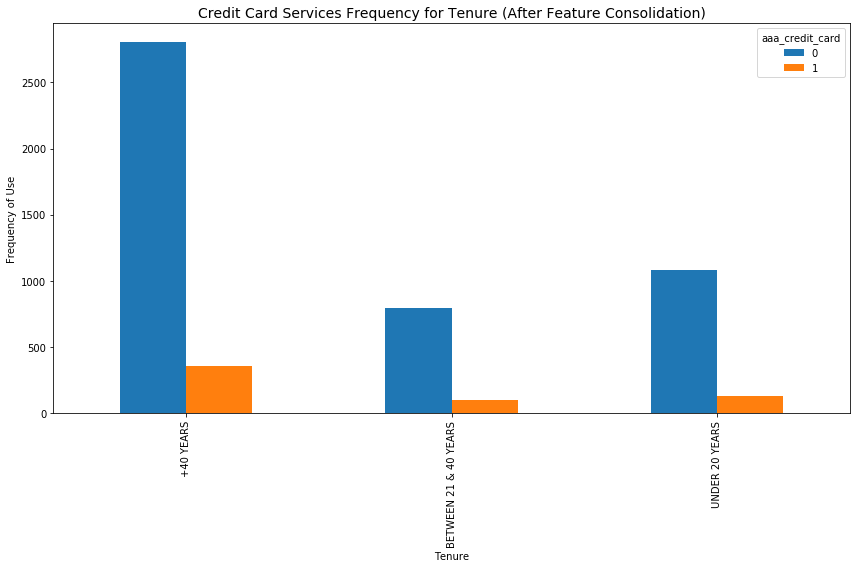

In [17]:
group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
group3 = ['+40 YEARS']
for i in group1:
    df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
for i in group2:
    df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
for i in group3:
    df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])

pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure (After Feature Consolidation)')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'tenure_use_feat_'+var_to_predict_save)
plt.show()

In [18]:
# Credit Ranges
df_household.credit_ranges.value_counts()

UNKNOWN       2503
750-799       1006
700-749        603
650-699        444
800+           417
600-649        201
550-599         47
500-549         37
499 & LESS       3
Name: credit_ranges, dtype: int64

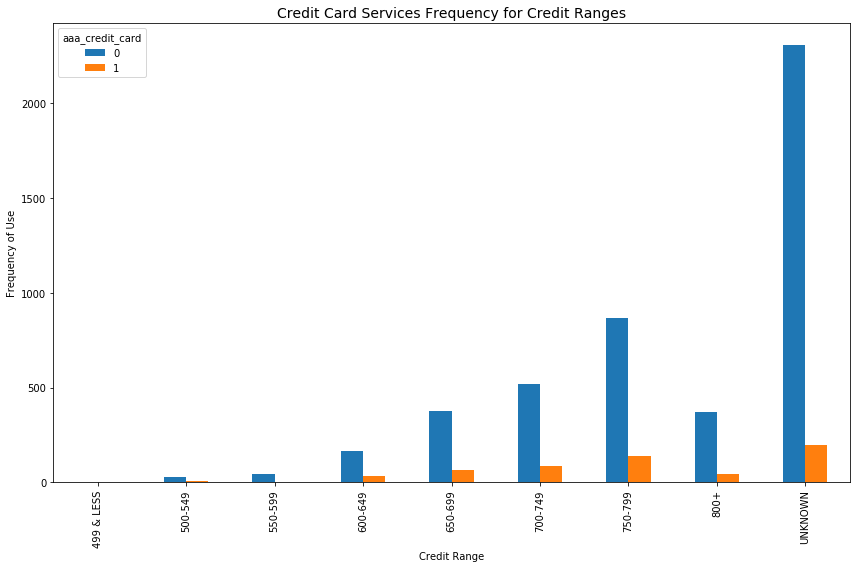

In [19]:
# graph credit ranges
pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'credit_ranges_use_'+var_to_predict_save)
plt.show()

# Outcomes
The frequency of auto Insurance Service use depend heavily on credit_ranges. Will consolidate tenure in three categories: 
    * a) above 800 years 
    * b) between 700 - 799 
    * c) Below 700

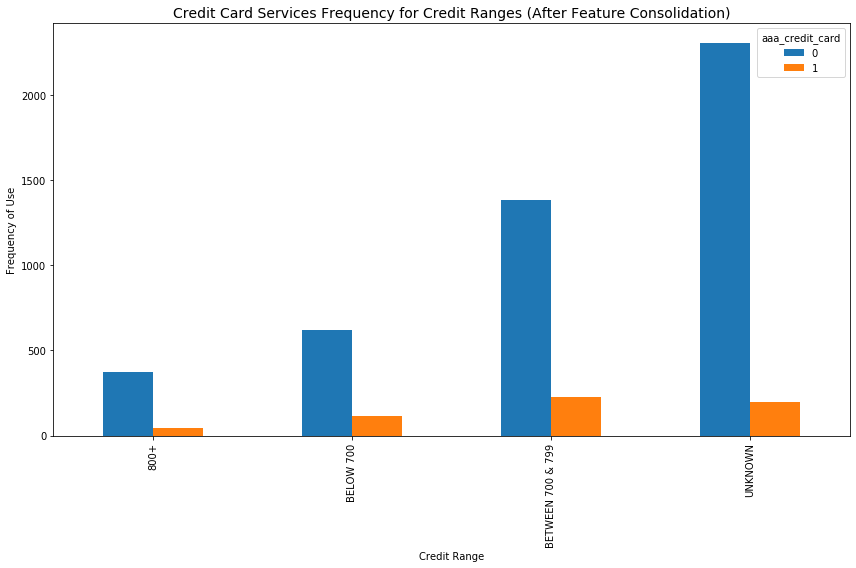

In [20]:
group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
group2 = ['700-749', '750-799']
group3 = ['800+']
for i in group1:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
for i in group2:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
for i in group3:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])

pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges (After Feature Consolidation)')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'credit_ranges_use_feat_'+var_to_predict_save)

In [21]:
# Education
df_household.education.value_counts()

UNKNOWN              3323
SOME COLLEGE          765
HIGH SCHOOL           738
COMPLETED COLLEGE     388
GRADUATED SCHOOL       47
Name: education, dtype: int64

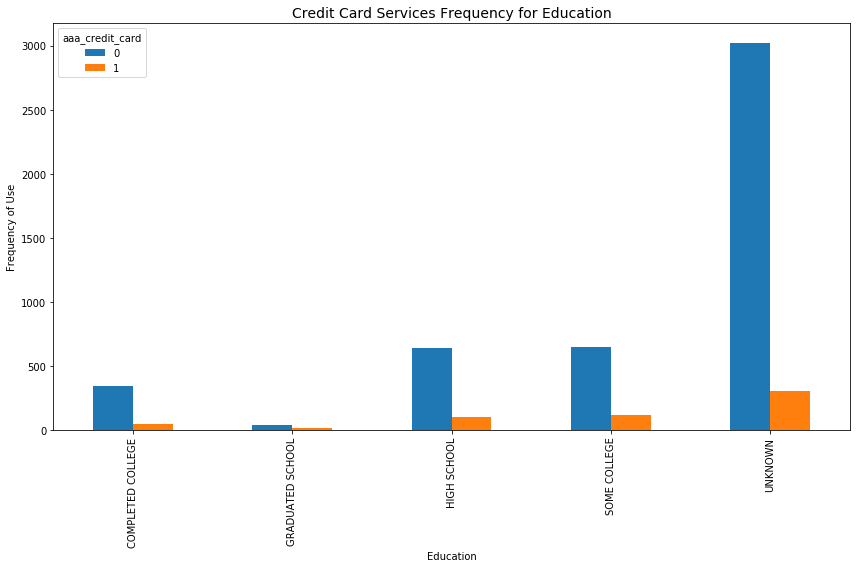

In [22]:
# graph education
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'education_use_'+var_to_predict_save)
plt.show()

# Outcomes
The frequency of credit card use depend heavily on education. Will consolidate graduate with completed collegue

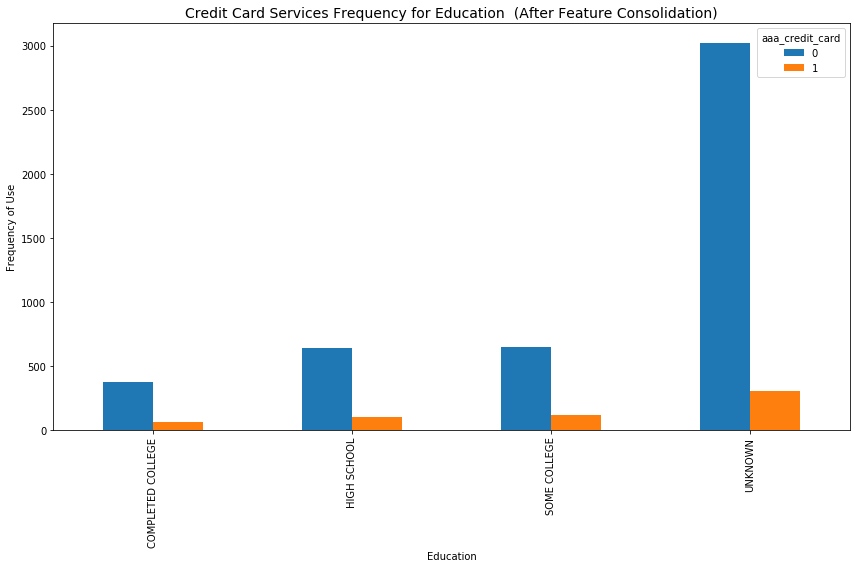

In [23]:
# graph education
df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education  (After Feature Consolidation)')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'education_use_feat_'+var_to_predict_save)
plt.show()

In [24]:
# Generation
df_household.generation.value_counts()

POST-WAR (< 1948)             3109
BABY BOOMERS (1948 - 1968)     979
UNKNOWN                        739
GENERATION X (1969 - 1980)     221
MILLENIALS (1981 - 1993)       200
GENERATION Z (1994 - 2010)      13
Name: generation, dtype: int64

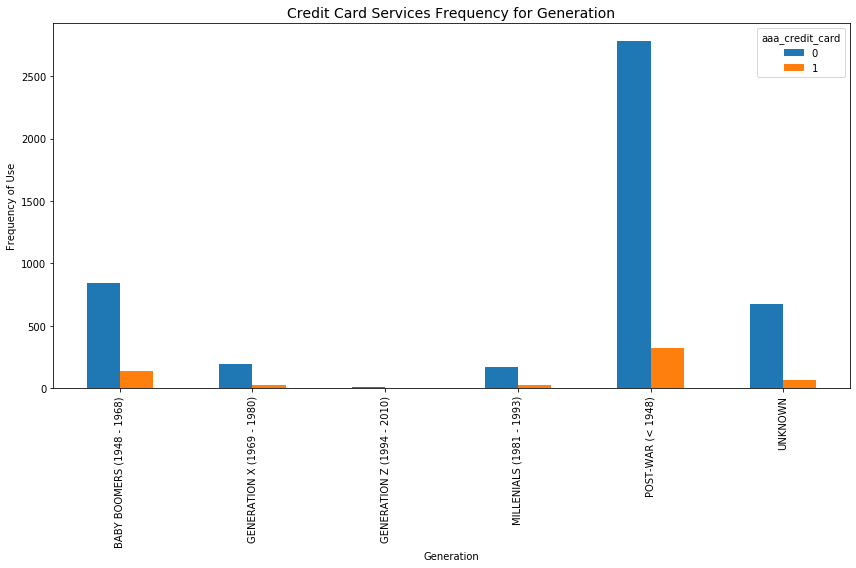

In [25]:
# graph Generation
pd.crosstab(df_household.generation,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Generation')
plt.xlabel('Generation')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'generation_use_'+var_to_predict_save)
plt.show()

In [26]:
# Race
df_household.race.value_counts()

UNKNOWN                                   2455
CAUCASION / WHITE - EUROPEAN              1287
CAUCASION / WHITE - ENGLISH                695
CAUCASION / WHITE - WHITE NON-AMERICAN     255
CAUCASION / WHITE - UNKNOWN                113
MIDDLE EASTERN - ARAB                      104
HISPANIC - HISPANIC ORIGIN                  97
CAUCASION / WHITE - EASTERN EUROPEAN        85
HISPANIC - PORTUGUESE ORIGIN                76
CAUCASION / WHITE - JEWISH                  22
ASIAN - CHINESE                             18
CAUCASION / WHITE - GREEK                   14
ASIAN - UNKNOWN                              9
AFRICAN AMERICAN - AFRICAN ORIGIN            9
AMERICAN INDIAN                              6
ASIAN - INDIAN                               6
MIDDLE EASTERN - EGYPTIAN                    4
ASIAN - JAPANESE                             4
ASIAN - ORIENTAL                             1
CAUCASION / WHITE - DUTCH                    1
Name: race, dtype: int64

In [27]:
# graph race
pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'race_use_'+var_to_predict_save)
plt.show()

# Observations
The frequency of credit card use depend heavily on race being caucasion- white group the predominant. 
I Will consolidate them in more similar groups
* a) Caucasion - White
* b) Hispanic
* c) Asian
* d) Arabs
* e) America Africans / Indians

In [28]:
group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

for i in group1:
    df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
for i in group2:
    df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
for i in group3:
    df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
for i in group4:
    df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
for i in group5:
    df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race (After Feature Consolidation)')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'race_use_feat_'+var_to_predict_save)
plt.show()

In [29]:
# Home Owner
df_household.home_owner.value_counts()

HOME OWNER             2641
UNKNOWN                2493
RENTER                  118
PROBABLE RENTER           6
PROBABLE HOME OWNER       3
Name: home_owner, dtype: int64

# Outcomes
The frequency of credit card use depend heavily on home_owner.  Will leave consolidate probable renter with RENTER and probable home owner with home owner 

In [30]:
# Home Owner
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])

pd.crosstab(df_household.home_owner,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Owner (After Feature Consolidation)')
plt.xlabel('Home Owner')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'home_owner_use_feat_'+var_to_predict_save)
plt.show()

In [31]:
# Cancel reason
df_household.cancel_reason.value_counts()

UNKNOWN                               2937
NON-PAYMENT                            870
DECEASED                               589
MEMBERS REQUEST                        331
NO LONGER DRIVING                      174
CANCELLED DO NOT RENEW                  77
TRANSFER MEMBER                         63
DUP MEMBERSHIP                          49
DATA PROBLEM                            49
TRANSFER MEMBER SUSPEND                 35
DO NOT RENEW                            25
MOVED OUT OF TERR                       25
CANCELLED MBRS REQUEST                   5
CANCEL PROCESS - RENEWAL NO PAY          5
NO LONGER IN HOUSEHOLD                   4
ERS DECLINE CC                           4
HEALTH ISSUE                             4
BAD ADD SET BY PO ACS                    2
CANCEL PROCESS - FUTURE CANCEL DNR       2
NONCOMPLIANT AGE                         2
*BAD CHECKS*                             2
NONCOMPLIANT ADDRESS                     1
RETIRED CD CANCEL MEMBER                 1
ERS EXCESS 

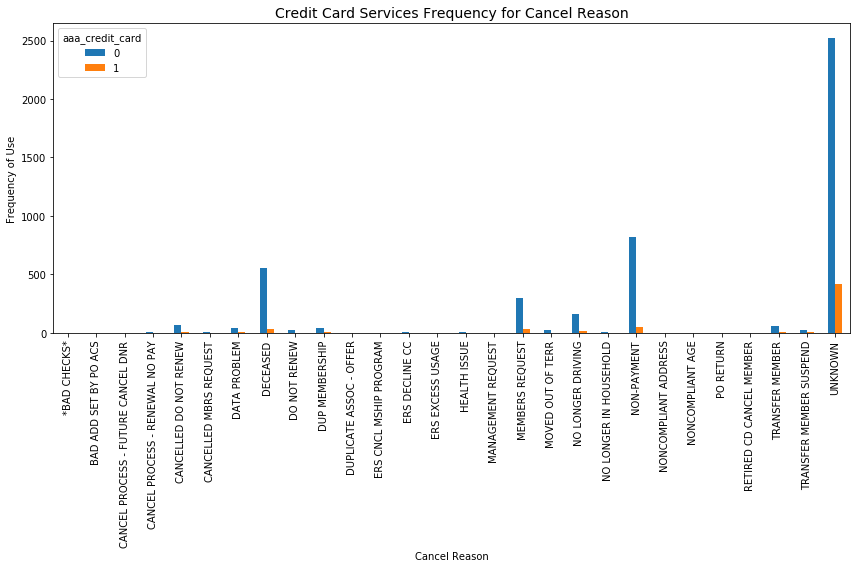

In [32]:
# graph Cancel Reason
pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason')
plt.xlabel('Cancel Reason')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'cancel_reason_use_'+var_to_predict_save)
plt.show()

# Observation
This Cancel Reason feature does not seems to be important to weather member choose or not CC. Even though, for instance those member that their suscription was cancelled or CC rejected, there might be an oportunity to get a CC if credit is available to them.  Will consolidate the reason in three main groups:
* a) PAYMENT ISSUES
* b) MEMBER ISSUES
* c) DATA/AAA ISSUES

UKNOWN will be replaced by 'NOT CANCELLED'  It is the largest group and a potential to customer.

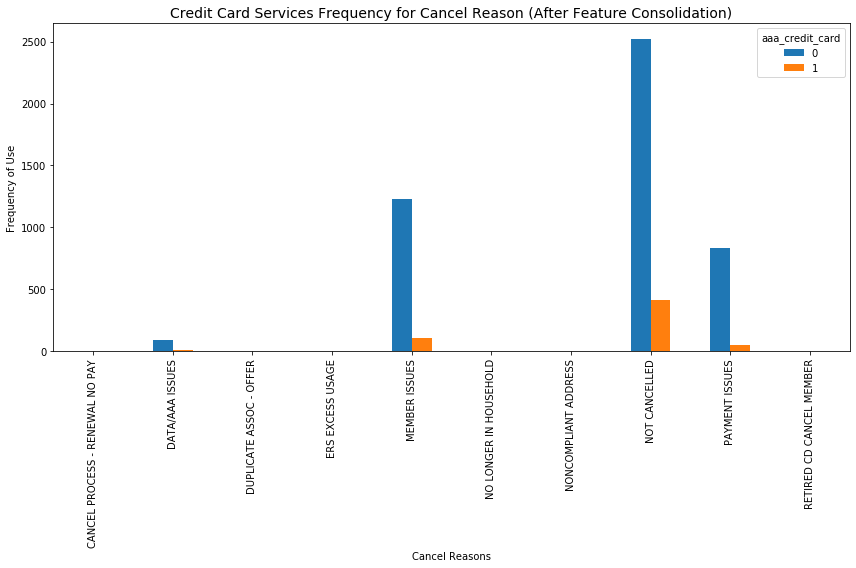

In [33]:
group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
          'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
          'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
         ]
group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

for i in group1:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
for i in group2:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
for i in group3:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

df_household['cancel_reason']=np.where(df_household['cancel_reason']== 'UNKNOWN', 'NOT CANCELLED', df_household['cancel_reason'])

pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason (After Feature Consolidation)')
plt.xlabel('Cancel Reasons')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'cancel_reason_use_feat_'+var_to_predict_save)
plt.show()

In [34]:
# mosaic_household
df_household.mosaic_household.value_counts()

UNKNOWN                       1530
AGING IN PLACE                 684
SILVER SOPHISTICATES           332
REAPING REWARDS                246
NO PLACE LIKE HOME             238
ROOTED FLOWER POWER            219
TOWN ELDERS                    196
SENIOR DISCOUNTS               173
AGING OF AQUARIUS              158
SETTLED IN SUBURBIA            140
FULL POCKETS  EMPTY NESTS      116
DIGITAL DEPENDENTS             108
BOHEMIAN GROOVE                 73
FAST TRACK COUPLES              72
BLUE COLLAR COMFORT             69
PLATINUM PROSPERITY             65
FAMILY FUN-TASTIC               61
AMERICAN ROYALTY                58
PROGRESSIVE POTPOURRI           51
STATUS SEEKING SINGLES          45
BOOMERS AND BOOMERANGS          44
GOLF CARTS AND GOURMETS         42
UNSPOILED SPLENDOR              41
BIRKENSTOCKS AND BEEMERS        39
MID-SCALE MEDLEY                39
PICTURE PERFECT FAMILIES        38
COUPLES WITH CLOUT              28
SETTLED AND SENSIBLE            25
TOUGH TIMES         

In [35]:
# graph Mosaic household
pd.crosstab(df_household.mosaic_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Household')
plt.xlabel('Mosaic Household')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'mosaic_household_use_'+var_to_predict_save)
plt.show()

In [36]:
# mosaic_household
df_household.mosaic_global_household.value_counts()

UNKNOWN                      1530
COMFORTABLE RETIREMENT       1168
BOURGEOIS PROSPERITY          843
ROUTINE SERVICE WORKERS       548
HARD WORKING BLUE COLLAR      267
CAREER AND FAMILY             245
POST INDUSTRIAL SURVIVORS     228
LOW INCOME ELDERS             222
METROPOLITAN STRUGGLERS       143
SOPHISTICATED SINGLES          64
RURAL INHERITANCE               3
Name: mosaic_global_household, dtype: int64

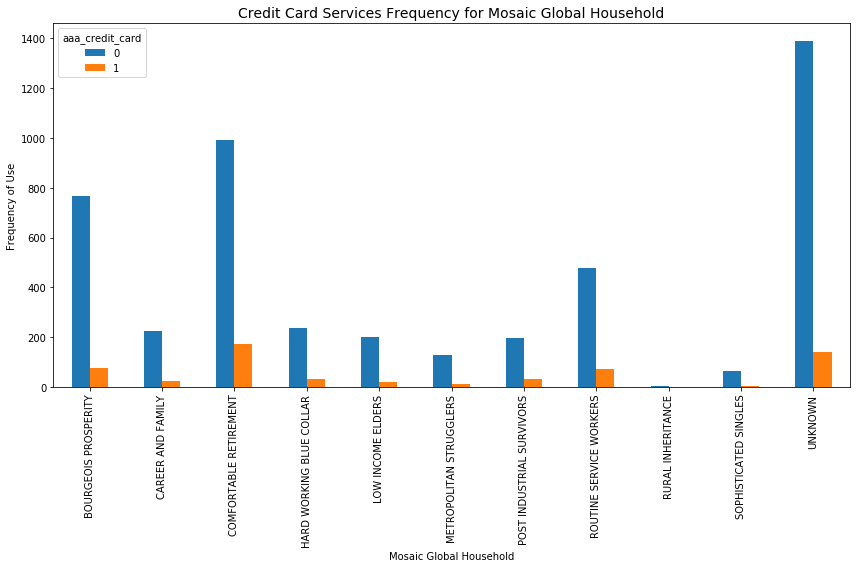

In [37]:
# graph Mosaic Global household
pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Global Household')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'mosaic_global_household_use_'+var_to_predict_save)
plt.show()

# Observation
Reviewing the graph above, these three groups can be consolidated in:
* a) METROPOLITAN STRUGGLERS into ROUTINE SERVICE WORKERS
* b) SOPHISTICATED SINGLES into BOURGEOIS PROSPERITY
* c) RURAL INHERITANCE into CAREER AND FAMILY
* d) POST INDUSTRIAL SURVIVORS into ROUTINE SERVICE WORKERS

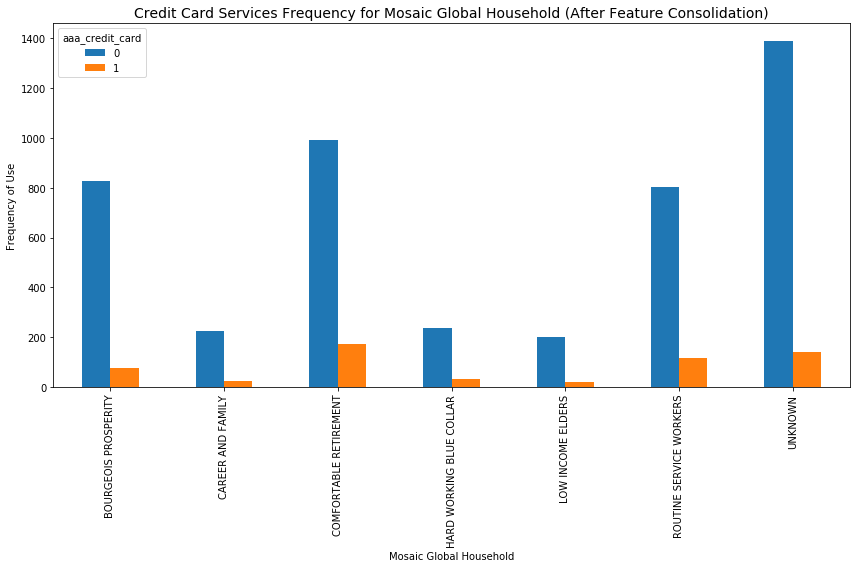

In [39]:
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                 'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                 'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                )
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Mosaic Global Household (After Feature Consolidation)')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'mosaic_global_household_use_feat_'+var_to_predict_save)
plt.show()

In [40]:
# kcl_b_ind_mosaicsgrouping
df_household.kcl_b_ind_mosaicsgrouping.value_counts()

UNKNOWN                     1530
AUTUMN YEARS                 713
GOLDEN YEAR GUARDIANS        619
BOOMING WITH CONFIDENCE      576
THRIVING BOOMERS             395
BLUE SKY BOOMERS             240
POWER ELITE                  195
SURBURBAN STYLE              174
SINGLES AND STARTERS         164
FAMILY UNION                 116
MIDDLE CLASS MELTING POT     107
FLOURISHING FAMILIES          95
SIGNIFICANT SINGLES           91
PROMISING FAMILIES            83
YOUNG CITY SOLOS              51
CULTURAL CONNECTIONS          47
ECONOMIC CHALLENGES           33
ASPIRATIONAL FUSION           22
FAMILIES IN MOTION             8
PASTORAL PRIDE                 2
Name: kcl_b_ind_mosaicsgrouping, dtype: int64

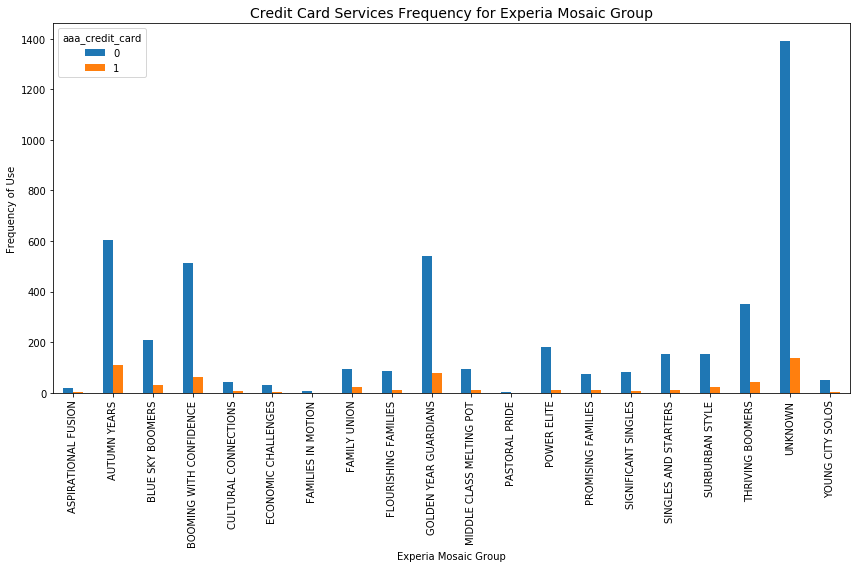

In [41]:
# graph kcl_b_ind_mosaicsgrouping
pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Experia Mosaic Group')
plt.xlabel('Experia Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'kcl_b_ind_mosaicsgrouping_use_'+var_to_predict_save)
plt.show()

# Observation
Reviewing the graph above, there are five dominant group here
* a) GOLDEN YEARS - retired people
* b) BOOMING - well established families
* c) POWER ELITE - powerufull wealth people
* d) FAMILY - middle class families
* e) Singles - singles or single moms.

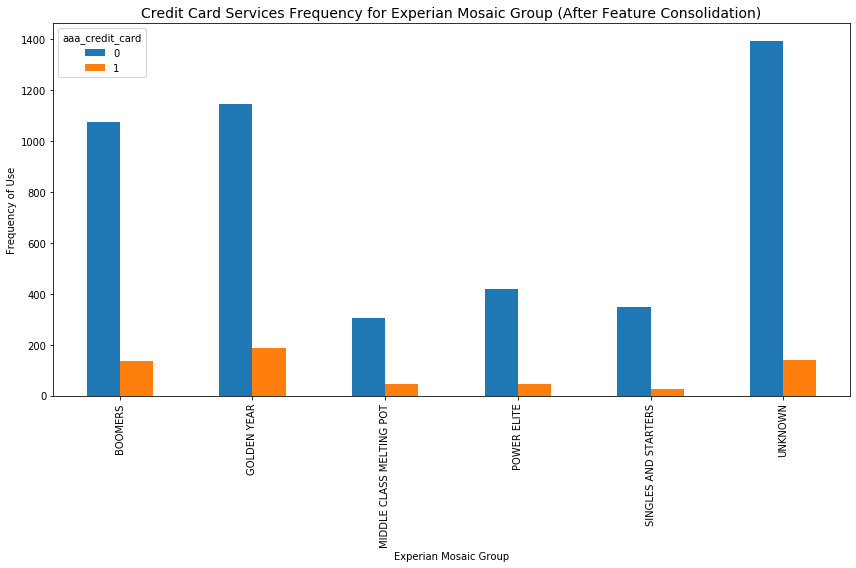

In [42]:
group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
          'PASTORAL PRIDE']
group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
         'ASPIRATIONAL FUSION']
for i in group1:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group2:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group3:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group4:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group5:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])

pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Experian Mosaic Group (After Feature Consolidation)')
plt.xlabel('Experian Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'kcl_b_ind_mosaicsgrouping_use_feat_'+var_to_predict_save)
plt.show()

In [43]:
# Vehicle Manufacturer
df_household.sc_vehicle_manufacturer_name.value_counts()

UNKNOWN            2652
TOYOTA              469
FORD                319
HONDA               285
CHEVROLET           202
NISSAN              130
HYUNDAI             122
BUICK               116
SUBARU               86
DODGE                78
CHRYSLER             66
JEEP                 60
LEXUS                60
MERCURY              52
VOLKSWAGEN           49
MERCEDES-BENZ        49
MAZDA                45
KIA                  44
VOLVO                44
CADILLAC             40
SATURN               32
BMW                  32
ACURA                32
GMC                  31
LINCOLN              28
PONTIAC              27
OLDSMOBILE           18
INFINITI             18
AUDI                 16
SAAB                 12
SCION                 7
MITSUBISHI            7
PLYMOUTH              6
LAND ROVER            6
MINI                  6
GEO                   3
FIAT                  3
JAGUAR                2
SUZUKI                2
AMERICAN AUSTIN       1
ALFA ROMEO            1
HARLEY DAVIDSON 

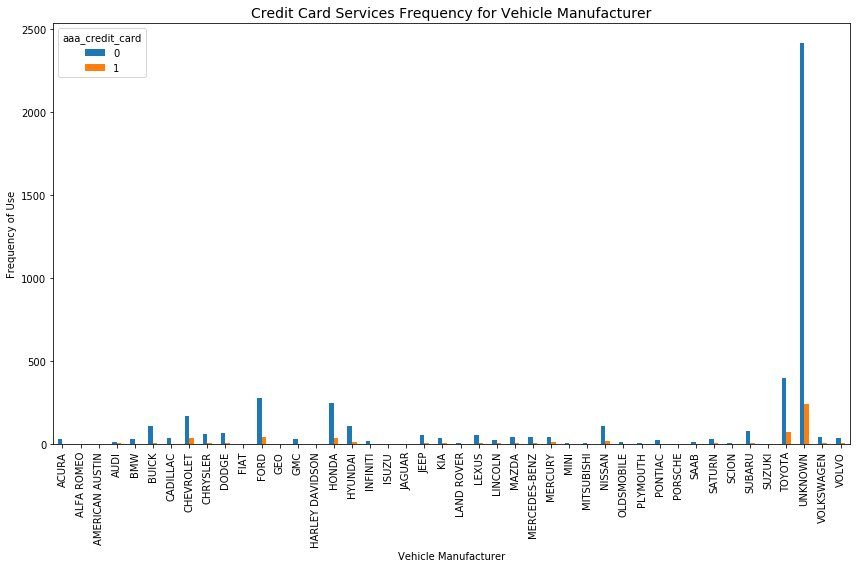

In [44]:
# graph Vehicle manufacturer
pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'vehicle_manufacturer_use_'+var_to_predict_save)
plt.show()

# Observation
Reviewing the graph above, there are four main group of car.  

* a) Standard for small families, and young professional, 
* b) Middle End - Middle class families and middle management
* c) High End - Success and upper management or people above 55 years no debts and no kids at school

Going to group the vehicle manufacturer in those three groups.

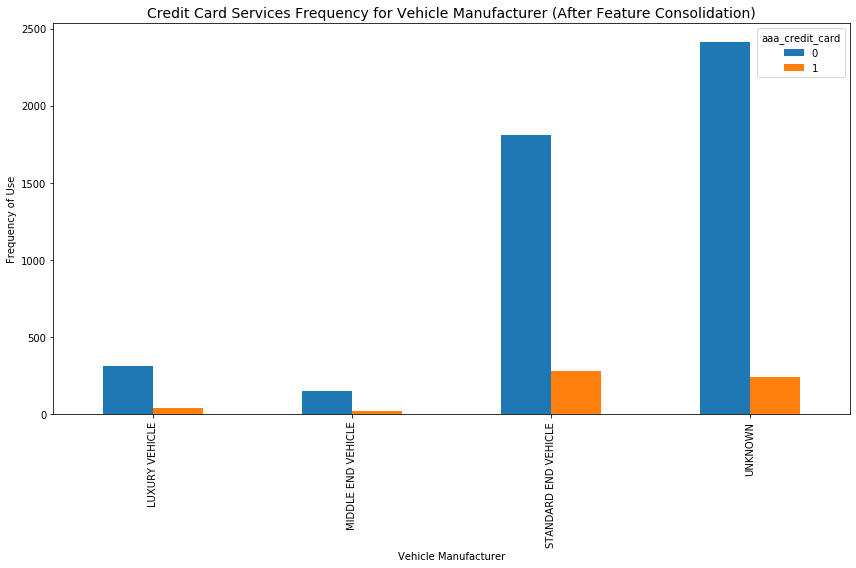

In [47]:
group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE', 'AMERICAN AUSTIN']
          
group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON', 'ALFA ROMEO']

for i in group1:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group2:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group3:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])


pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer (After Feature Consolidation)')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'vehicle_manufacturer_use_feat_'+var_to_predict_save)
plt.show()

In [48]:
# Occupation Code
df_household.occupation_code.value_counts()

UNKNOWN                            4359
RETIRED                             216
PROFESSIONAL/TECHNICAL              119
UPPER MANAGEMENT/EXECUTIVE           80
NURSE                                75
CLERICAL/OFFICE                      60
SKILLEDTRADE/MACHINE/LABORER         56
TEACHER/EDUCATOR                     54
MIDDLE MANAGEMENT                    51
SALES/MARKETING                      28
BEAUTY                               21
REAL ESTATE                          17
SELF EMPLOYED                        14
ATTORNEYS                            11
EXECUTIVE/ADMINISTRATOR              11
HEALTH SERVICES                       9
COUNSELORS                            8
PROFESSIONAL DRIVER                   7
PHARMACIST                            6
ENGINEERS                             5
COMPUTER PROFESSIONAL                 5
RETAIL SALES                          5
DENTIST/DENTAL HYGIENIST              5
CIVIL SERVANT                         4
DOCTORS/PHYSICIANS/SURGEONS           4


In [49]:
df_household.occupation_group.value_counts()

UNKNOWN                             3236
RETIRED - INFERRED                   631
PROFESSIONAL - KNOWN                 300
RETIRED - KNOWN                      216
MANAGEMENT - KNOWN                   151
MANAGEMENT - INFERRED                106
OTHER - INFERRED                      82
PROFESSIONAL - INFERRED               80
BLUE COLLAR - INFERRED                72
OFFICE ADMINISTRATION - INFERRED      72
BLUE COLLAR - KNOWN                   65
OFFICE ADMINISTRATION - KNOWN         60
SALES - KNOWN                         50
TECHNICAL - INFERRED                  47
OTHER - KNOWN                         45
SALES - INFERRED                      33
TECHNICAL - KNOWN                     15
Name: occupation_group, dtype: int64

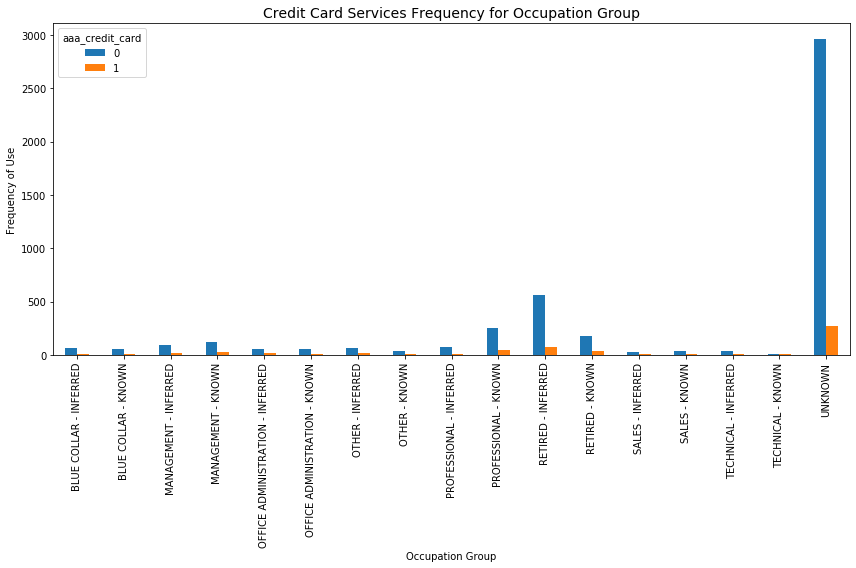

In [50]:
# graph ocuppation group
pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Occupation Group')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'occupation_group_use_'+var_to_predict_save)
plt.show()

# Observation
Reviewing the graph above, there are 4 prodominat group
* a) PROFESSIONAL
* b) MANAGEMENT
* c) RETIRED
* d) OTHERS

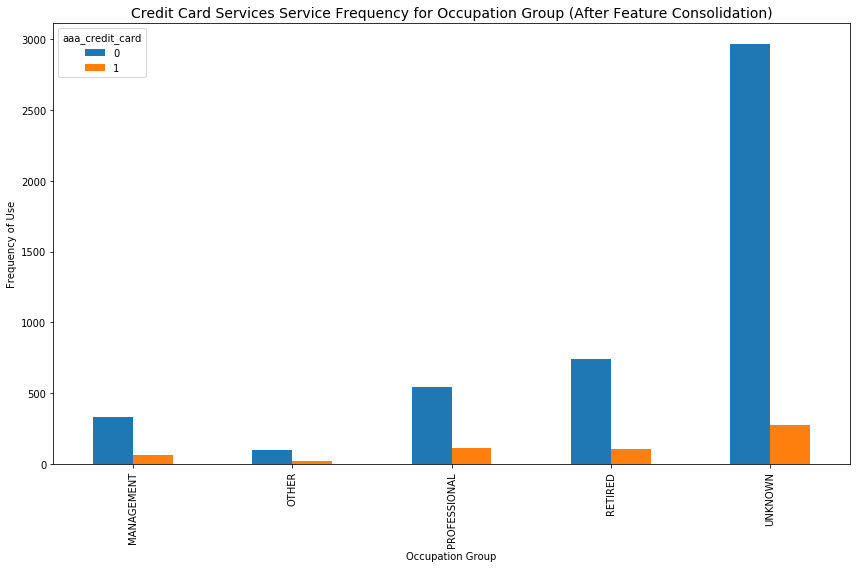

In [52]:
group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

for i in group1:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
for i in group2:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
for i in group3:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
for i in group4:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])


pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Service Frequency for Occupation Group (After Feature Consolidation)')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'occupation_group_use_feat_'+var_to_predict_save)
plt.show()

In [53]:
# graph occupant type
df_household.occupant_type.value_counts()

UNKNOWN      5083
HOMEOWNER     122
RENTER         56
Name: occupant_type, dtype: int64

In [54]:
# graph member status
df_household.member_status.value_counts()

ACTIVE       2662
CANCELLED    2324
PENDING       275
Name: member_status, dtype: int64

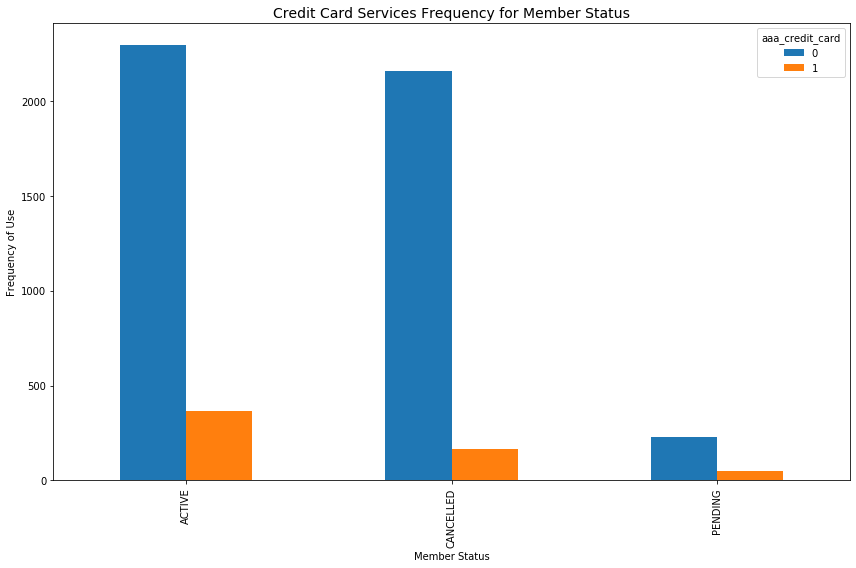

In [55]:
# graph member status group
pd.crosstab(df_household.member_status,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Member Status')
plt.xlabel('Member Status')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'member_status_use_'+var_to_predict_save)
plt.show()

In [56]:
# graph Auto Insurance
df_household.aaa_auto_insurance.value_counts()

0    3816
1    1445
Name: aaa_auto_insurance, dtype: int64

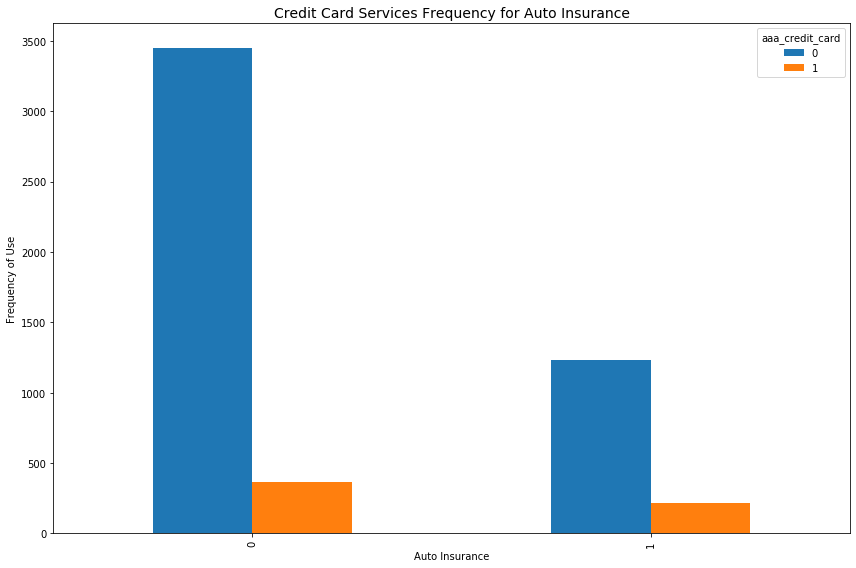

In [57]:
# graph Auto Insurance service
pd.crosstab(df_household.aaa_auto_insurance,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Auto Insurance')
plt.xlabel('Auto Insurance')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'auto_insurance_status_use_'+var_to_predict_save)

In [ ]:
# graph Financial service
df_household.aaa_financial_service.value_counts()

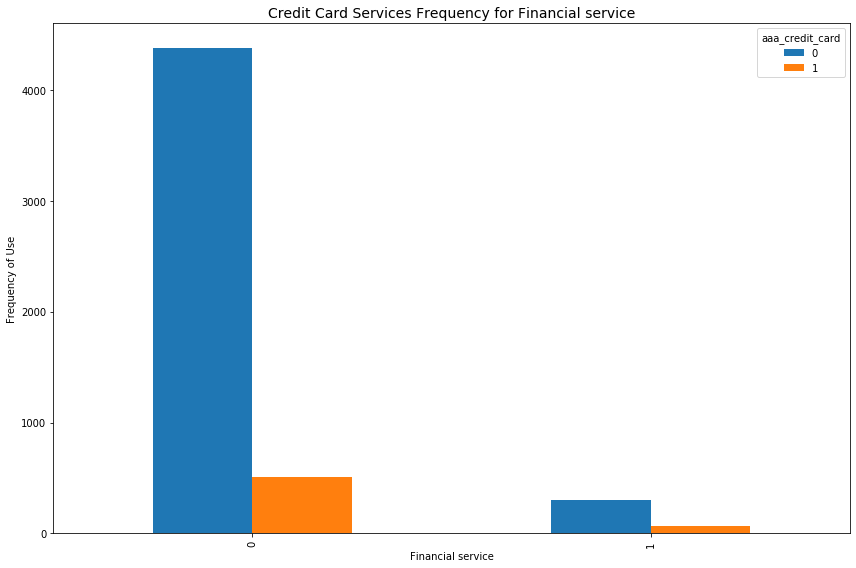

In [58]:
# graph Financial service
pd.crosstab(df_household.aaa_financial_service,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Financial service')
plt.xlabel('Financial service')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'financial_service_use_'+var_to_predict_save)
plt.show()

In [59]:
# graph home_equity
df_household.aaa_home_equity.value_counts()

0    5255
1       6
Name: aaa_home_equity, dtype: int64

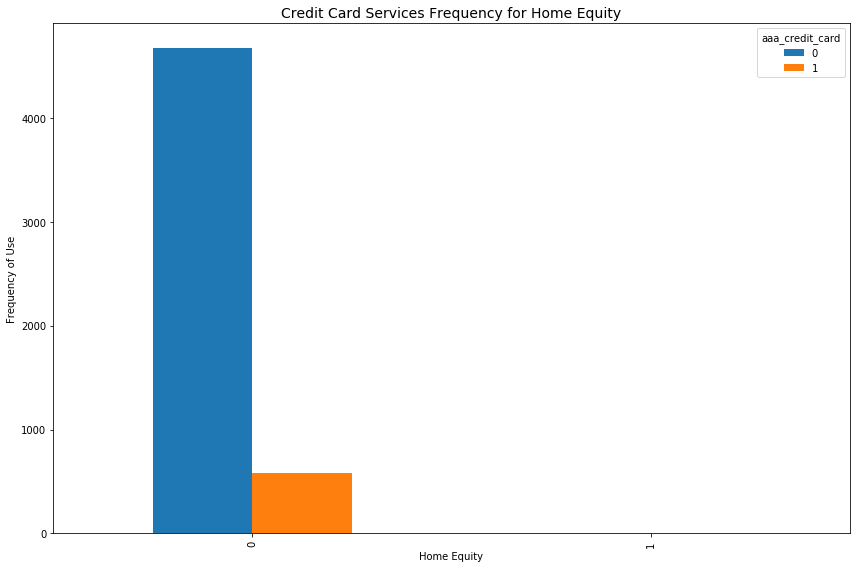

In [60]:
# graph home_equity
pd.crosstab(df_household.aaa_home_equity,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Equity')
plt.xlabel('Home Equity')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'home_equity_use_'+var_to_predict_save)
plt.show()

In [61]:
# graph deposit
df_household.aaa_deposit.value_counts()

0    5233
1      28
Name: aaa_deposit, dtype: int64

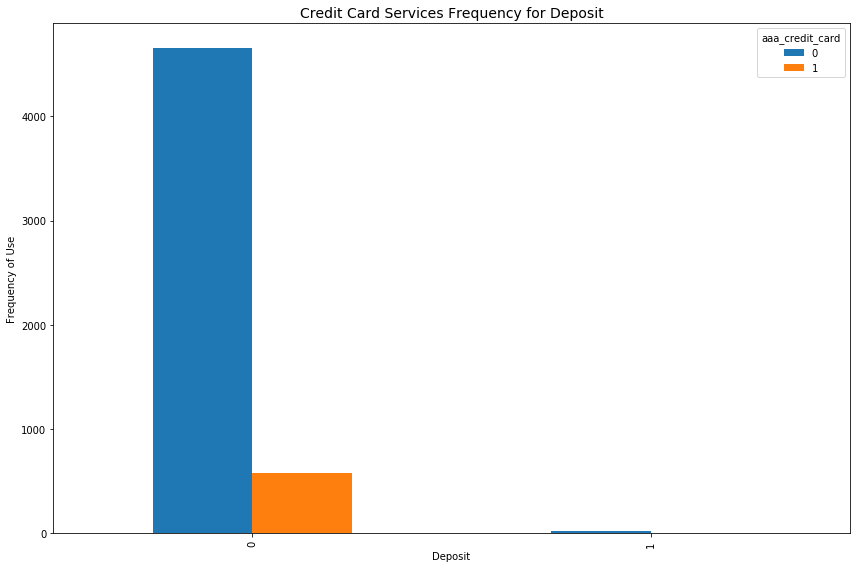

In [62]:
# graph Deposit
pd.crosstab(df_household.aaa_deposit,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Deposit')
plt.xlabel('Deposit')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'deposit_use_'+var_to_predict_save)
plt.show()

In [63]:
# graph aaa_mortgage
df_household.aaa_mortgage.value_counts()

0    4893
1     368
Name: aaa_mortgage, dtype: int64

In [64]:
# graph Mortgage group
pd.crosstab(df_household.aaa_mortgage,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mortgage')
plt.xlabel('Mortgage')
plt.ylabel('Frequency of Use')
plt.savefig('./model_pics/credit_card/'+'mortgage_use_'+var_to_predict_save)
plt.show()

In [65]:
# graph use roadside
df_household.use_road_side.value_counts()

1    3067
0    2194
Name: use_road_side, dtype: int64

In [66]:
# graph roadside use
pd.crosstab(df_household.use_road_side,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Use Roadside')
plt.xlabel('Use Roadside Service')
plt.ylabel('Frequency of Use')
plt.grid()
plt.savefig('./model_pics/credit_card/'+'road_side_use_'+var_to_predict_save)
plt.show()

In [67]:
# graph id theft
df_household.aaa_id_theft.value_counts()

0    5026
1     235
Name: aaa_id_theft, dtype: int64

In [68]:
# graph auto id theft
pd.crosstab(df_household.use_road_side,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for ID Theft')
plt.xlabel('ID Theft Service')
plt.ylabel('Frequency of Use')
plt.grid()
plt.savefig('./model_pics/Auto Insurance/'+'id_theft_use_'+var_to_predict_save)
plt.show()

# Model to predict Credit Card Service Usage by household key

Previous Columns Used
* cols_house_dummmies = ['income', 'tenure', 'credit_ranges','education', 'generation', 'cancel_reason',
                       'race', 'home_owner', 'dwelling_type', 'mosaic_global_household',
                       'plus_indicator_description', 'gender', 'mosaic_household',
                       'kcl_b_ind_mosaicsgrouping', 'sc_vehicle_manufacturer_name'
                       occupation_code, occupation_group, occupant_type, vehicle, sc_vehicle_model_name

* feature_cols = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                    'total_calls', 'total_member_cost', 'total_cost', 'mean_total_member_cost', 'mean_total_cost'
* feature_cols = ['no_members', 'total_calls', 'mean_total_member_cost', 'mean_total_cost',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost']

# Final Observation (Need update)

Based on the previous anlysis, these are the most important feature:
* income
* tenure
* credit_ranges
* education
* generation
* race
* home_owner
* cancel_reason
* mosaic_global_household
* plus_indicator_description
* Gender
* kcl_b_ind_mosaicsgrouping
* sc_vehicle_manufacturer_name
* occupation_group


In [5]:
# Re initiate all features and data
def reiniciar(df_household):
    df_household = read_data('household_view.csv')
    
    # Regroup Group Income
    group1 = ['UNDER 10K','10-19,999' , '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE', 'AMERICAN AUSTIN']
          
    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON', 'ALFA ROMEO']


    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    # Regroup Total members inside a household
    df_household['no_members'] = ' '
    df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                        df_household['no_members'])

    df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                        df_household['no_members'])
    group5 = np.arange(5,20,1)
    for i in group5:
        df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                        df_household['no_members'])
    
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
    
    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                        df_household.consumer_score)
    
    df_household.consumer_score = np.where(~(df_household.consumer_score > 0), df_household.consumer_score.mean(), 
                                           df_household.consumer_score)
    
    #df_household.consumer_score = np.where(df_household.consumer_score== np.nan, df_household.consumer_score.mean(), 
    #                                    df_household.consumer_score)
    
    # create feature Cancel = 1 - member cancelled, if 0 active member
    df_household['aaa_cancel'] = 1
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'ACTIVE', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'PENDING', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'CANCELLED', 1, 
                                        df_household['aaa_cancel'])
    
    return df_household

In [6]:
df_household.groupby(by=var_to_predict)['total_cost'].mean()

aaa_credit_card
0   122.0250
1   151.6986
Name: total_cost, dtype: float64

In [7]:
df_household.groupby(by=var_to_predict)['total_calls'].mean()

aaa_credit_card
0   7.4377
1   9.3914
Name: total_calls, dtype: float64

In [8]:
df_household.groupby(by=var_to_predict)['total_member_cost'].mean()

aaa_credit_card
0   397.4876
1   488.0123
Name: total_member_cost, dtype: float64

In [74]:
df_household.groupby(by=var_to_predict)['basic_cost'].mean()

aaa_credit_card
0   109.4678
1   141.3932
Name: basic_cost, dtype: float64

In [75]:
df_household.groupby(by=var_to_predict)['plus_cost'].mean()

aaa_credit_card
0   9.1747
1   8.9190
Name: plus_cost, dtype: float64

In [76]:
df_household.groupby(by=var_to_predict)['premier_cost'].mean()

aaa_credit_card
0   0.0205
1   0.0000
Name: premier_cost, dtype: float64

# Type of correlation
http://blogeducativope-t5.blogspot.com/2018/05/514-linear-correlation-coefficient.html
Our threshold will be set up to 0.75 to -0.75 meaning it will only use upt to moderate correlation 

# Correlation Analysis
librimind.com: 'Data columns with very similar trends are also likely to carry very similar information. In this case, only one of them will suffice to feed the machine learning model. Here we calculate the correlation coefficient between numerical and nominal columns as the Coefficient and the Pearson’s chi square value respectively. Pairs of columns with correlation coefficient higher than a threshold are reduced to only one.

In [77]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 89 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

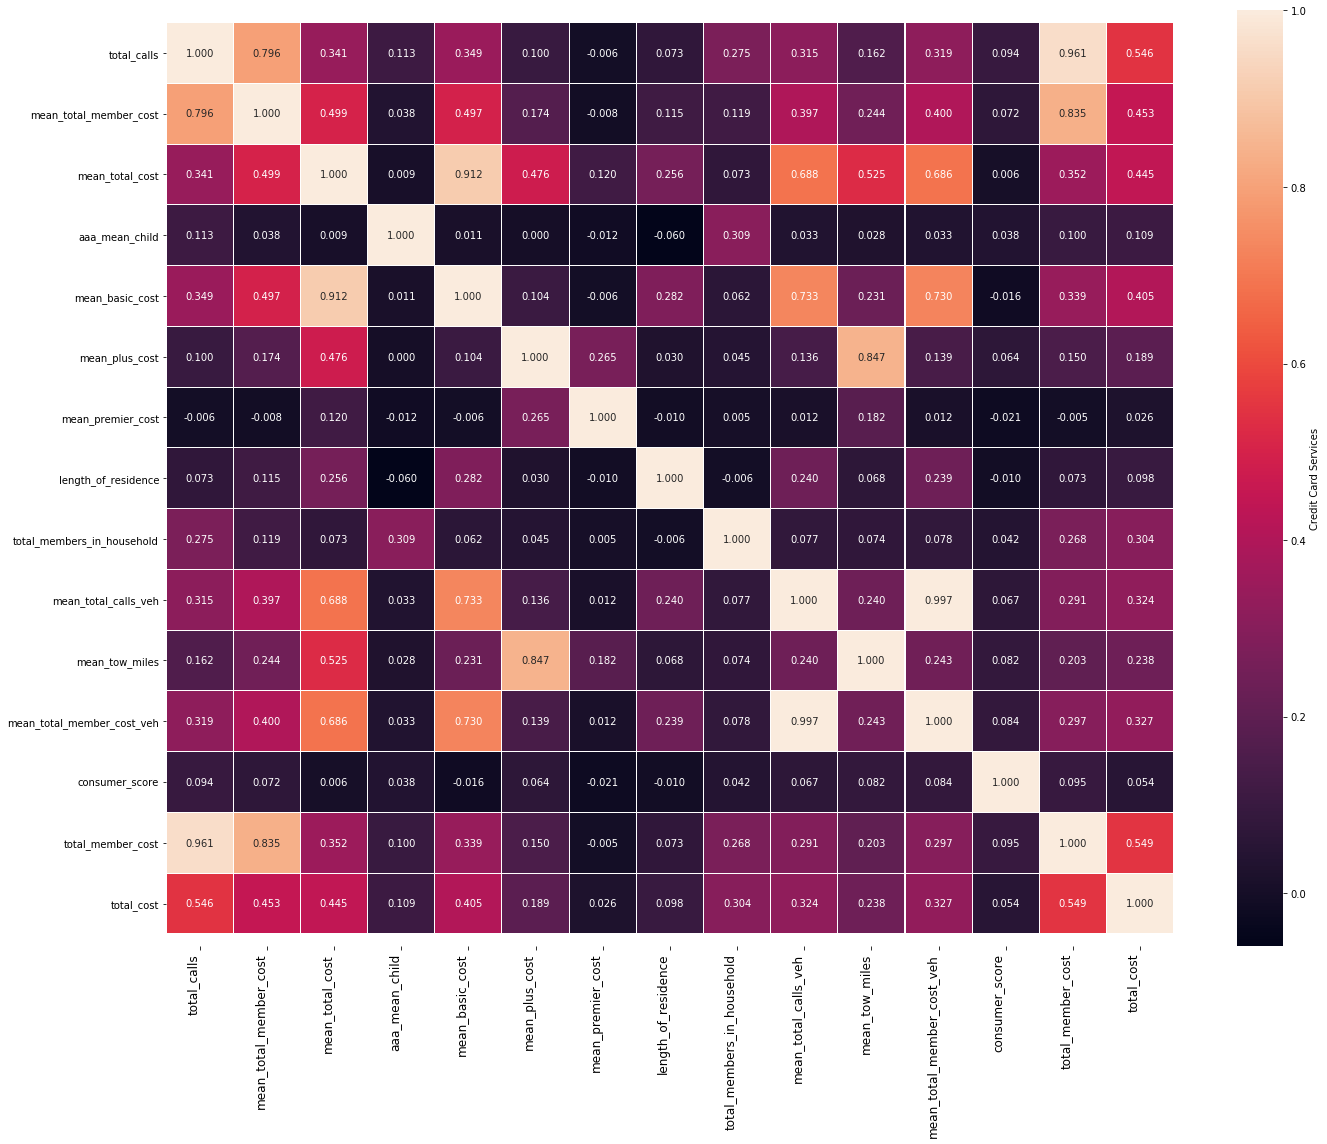

In [10]:
# Select all numeric features from df_household
# Get only numeric columns
# col_num = df_household.select_dtypes(include=np.number).columns.tolist()
# Removed: basic_costs, plus_cost, total_member_cost, total_cost_veh - All highly correlated so decided to remove them
col_num =['total_calls', 'mean_total_member_cost', 'mean_total_cost', 'aaa_mean_child',
          'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost', 'length_of_residence',
          'total_members_in_household', 'mean_total_calls_veh','mean_tow_miles',
          'mean_total_member_cost_veh', 'consumer_score', 'total_member_cost', 'total_cost'
         ]

df_corr = pd.DataFrame(df_household, columns=col_num)
df_corr = df_corr.corr()
plt.figure(figsize=(20,16))
sns.heatmap(df_corr, annot=True, fmt=".3f", linewidths=0.1, xticklabels=True, 
                cbar_kws={'label': var_to_predict_title}, yticklabels=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_var_corr')
plt.show()

In [11]:
# Correlation
df_corr = pd.DataFrame(df_household, columns=col_num)
df_corr = df_corr.corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

#cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(df_corr, mask=mask, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_var_corr_1')
plt.show()

In [12]:
# Remove columns with strong correlation
# Columns to remove =  ['mean_total_member_cost', 'total_member_cost', 'mean_basic_cost', 'mean_plus_cost'
#                      'mean_total_member_cost_veh',]

col_num =['total_calls', 'mean_total_cost', 'aaa_mean_child',
           'mean_premier_cost', 'length_of_residence',
          'total_members_in_household', 'mean_total_calls_veh','mean_tow_miles',
          'consumer_score', 'total_cost'
         ]


# Correlation
df_corr = pd.DataFrame(df_household, columns=col_num)
df_corr = df_corr.corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

#cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(df_corr, mask=mask, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_var_corr_2')
plt.show()

# Reload data to conduct another experiment

In [13]:
# Reload data to conduct another experiment
df_household = reiniciar(df_household)


cols_house_dummmies = ['credit_ranges','education', 'generation', 'income','aaa_financial_service',
                       'no_members', 'kcl_b_ind_mosaicsgrouping', 'aaa_auto_insurance', 
                       'aaa_id_theft', 'aaa_travel', 'occupation_group', 'mosaic_global_household',
                       'use_road_side'
                      ]
feature_cols = col_num.copy()

# Build Dummies Variables
df_dummies = pd.get_dummies(df_household, columns=cols_house_dummmies)
for i in cols_house_dummmies:
    cols = [j for j in df_dummies.columns if j.startswith(i)]
    feature_cols += cols

# construct Dataframe for prediction
feature_cols += var_to_predict
df_prediction = pd.DataFrame(df_dummies, columns=feature_cols)

# Stripping out spaces from ends of names, and replacing internal spaces with "_"
df_prediction.columns = [col.strip().replace(' ', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('&', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('+', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(',', '').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('(', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(')', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('<', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('.', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('/', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('-', '_').lower() for col in df_prediction.columns]

# Fix Nans
# Number of child
df_prediction.aaa_mean_child.fillna(value=0, inplace=True)
# Drop records with no age
#df_prediction = df_prediction[~df_prediction.aaa_mean_age.isna()]
# Drop Unknown Columns 
cols_to_drop = [j for j in df_prediction.columns if j.endswith('unknown')]
df_prediction.drop(labels=cols_to_drop,axis=1, inplace=True)

# Save columns name for future use in modelling to split X-Input and y-Output
X_cols = df_prediction.columns[:-1]
y_cols = var_to_predict.copy()

In [120]:
df_prediction.describe()

total_calls  mean_total_cost  aaa_mean_child  mean_premier_cost  length_of_residence  total_members_in_household  mean_total_calls_veh  mean_tow_miles  consumer_score  total_cost  credit_ranges_800_  credit_ranges_below_700  credit_ranges_between_700___799  education_completed_college  education_high_school  education_some_college  generation_baby_boomers__1948___1968_  generation_generation_x__1969___1980_  generation_generation_z__1994___2010_  generation_millenials__1981___1993_  generation_post_war____1948_  income_100k_  income_40___99999  income_under_39999  aaa_financial_service_0  aaa_financial_service_1  no_members__5___member  no_members_1___member  no_members_2___member  no_members_3___member  no_members_4___member  kcl_b_ind_mosaicsgrouping_boomers  kcl_b_ind_mosaicsgrouping_golden_year  kcl_b_ind_mosaicsgrouping_middle_class_melting_pot  kcl_b_ind_mosaicsgrouping_power_elite  kcl_b_ind_mosaicsgrouping_singles_and_starters  aaa_auto_insurance_0  \
count    5261.0000        5261.0000       5261.0000          5261.0000            5261.0000                   5261.0000             5261.0000       5261.0000       5261.0000   5261.0000           5261.0000                5261.0000                        5261.0000                    5261.0000              5261.0000               5261.0000                              5261.0000                              5261.0000                              5261.0000                            5261.0000                     5261.0000     5261.0000          5261.0000           5261.0000                5261.0000                5261.0000               5261.0000              5261.0000              5261.0000              5261.0000              5261.0000                          5261.0000                              5261.0000                                          5261.0000                               5261.0000                                       5261.0000             5261.0000   
mean        7.6531          22.5209          1.1809             0.0059               5.9915                      2.3458                1.4624          1.0075          0.0149    125.2964              0.0793                   0.1391                           0.3058                       0.0827                 0.1403                  0.1454                                 0.1861                                 0.0420                                 0.0025                               0.0380                        0.5910        0.1849             0.2604              0.0969                   0.9301                   0.0699                  0.0703                 0.2895                 0.3625                 0.1772                 0.1006                             0.2302                                 0.2532                                             0.0663                                  0.0882                                          0.0713                0.7253   
std        18.9576          21.7579          1.1207             0.3748               5.8162                      1.3338                1.3309          3.0687          0.0011    265.5425              0.2702                   0.3461                           0.4608                       0.2754                 0.3473                  0.3525                                 0.3892                                 0.2006                                 0.0497                               0.1913                        0.4917        0.3883             0.4389              0.2959                   0.2551                   0.2551                  0.2557                 0.4536                 0.4808                 0.3818                 0.3008                             0.4210                                 0.4349                                             0.2489                                  0.2836                                          0.2573                0.4464   
min         0.0000           0.0000          0.0000             0.0000             

In [121]:
#  Correlation of AAA Mortage Service 
df_prediction.corr()

total_calls  mean_total_cost  aaa_mean_child  mean_premier_cost  length_of_residence  total_members_in_household  mean_total_calls_veh  mean_tow_miles  consumer_score  total_cost  credit_ranges_800_  credit_ranges_below_700  credit_ranges_between_700___799  education_completed_college  education_high_school  education_some_college  generation_baby_boomers__1948___1968_  generation_generation_x__1969___1980_  generation_generation_z__1994___2010_  generation_millenials__1981___1993_  generation_post_war____1948_  income_100k_  income_40___99999  income_under_39999  aaa_financial_service_0  aaa_financial_service_1  no_members__5___member  no_members_1___member  no_members_2___member  no_members_3___member  no_members_4___member  kcl_b_ind_mosaicsgrouping_boomers  kcl_b_ind_mosaicsgrouping_golden_year  kcl_b_ind_mosaicsgrouping_middle_class_melting_pot  kcl_b_ind_mosaicsgrouping_power_elite  \
total_calls                                              1.0000           0.3414          0.1586            -0.0057               0.0728                      0.2751                0.3153          0.1620          0.0944      0.5458              0.0227                   0.0588                           0.0087                       0.0226                 0.0154                  0.0085                                 0.0965                                 0.0732                                 0.0680                               0.1332                       -0.1205        0.0356             0.0257              0.0206                  -0.0987                   0.0987                  0.2090                -0.1416                -0.0868                 0.0355                 0.1296                             0.0140                                -0.0473                                             0.0342                                  0.0350   
mean_total_cost                                          0.3414           1.0000          0.1920             0.1204               0.2558                      0.0731                0.6883          0.5252          0.0062      0.4450              0.0675                   0.1093                           0.1057                       0.0598                 0.0783                  0.0914                                 0.1154                                 0.0591                                 0.0359                               0.0704                       -0.0255        0.1032             0.1035              0.0710                  -0.0739                   0.0739                  0.0355                -0.0482                -0.0300                 0.0283                 0.0545                             0.0288                                 0.0577                                             0.0017                                 -0.0026   
aaa_mean_child                                           0.1586           0.1920          1.0000            -0.0017               0.4622                      0.3786                0.1951          0.0787          0.0332      0.1909              0.1239                   0.1612                           0.3312                       0.1345                 0.2116                  0.1793                                 0.1529                                 0.1542                                 0.0486                               0.1362                       -0.1675        0.2897             0.2524              0.0718                  -0.1477                   0.1477                  0.2308                -0.2687                -0.0957                 0.1374                 0.1876                             0.0596                                 0.0269                                             0.0491                                  0.1569   
mean_premier_cost                                       -0.0057           0.1204         -0.0017             1.0000              -0.0100                      0.0055                0.0121          0.1821         -0.0208      0.02

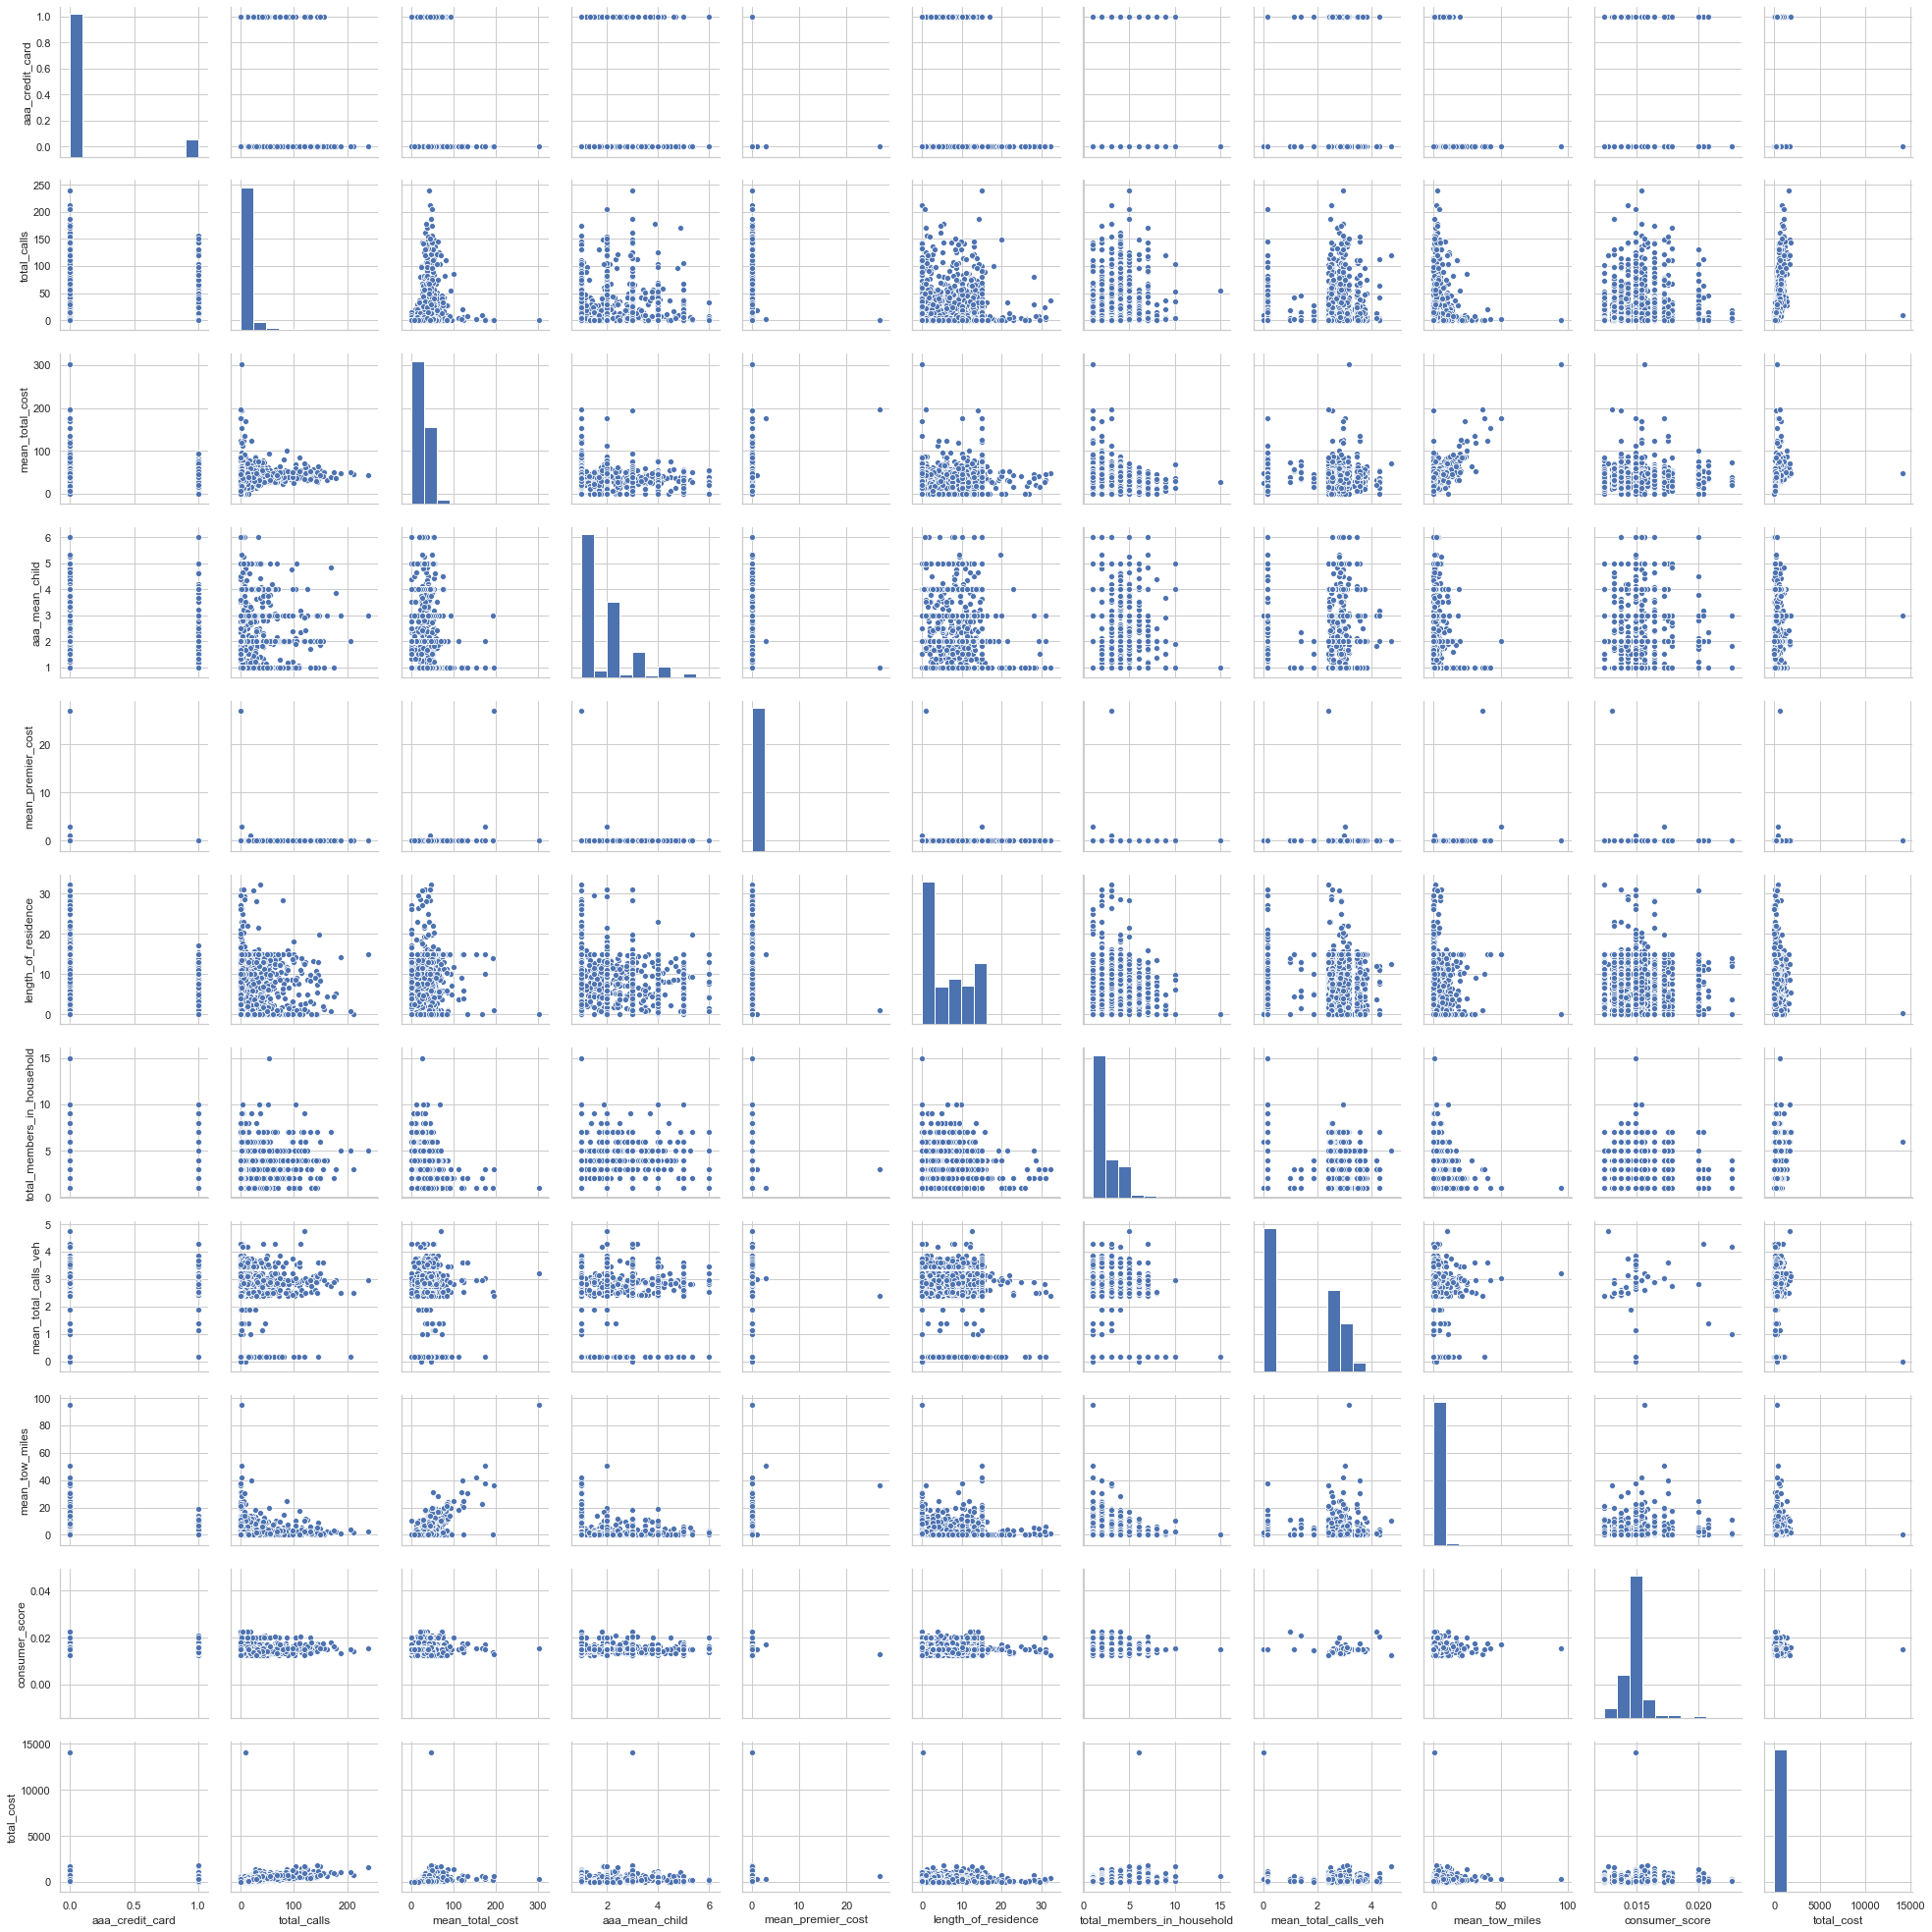

In [122]:
# Pair plot 
sns.pairplot(df_household[var_to_predict+col_num])
plt.show()

In [123]:
#  Correlation of AAA Costs and other numeric features
# Heat Map 
df_corr = df_prediction.corr()
df_corr.sort_values(by=var_to_predict[0], ascending=False, inplace=True)
df_corr = df_corr[df_corr.index.values!=var_to_predict[0]]
plt.figure(figsize=(20,16))
sns.heatmap(df_corr[[var_to_predict[0]]], annot=True, fmt=".3f", linewidths=0.1, xticklabels=True, 
                cbar_kws={'label': var_to_predict_title}, yticklabels=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.9, top - 0.9)
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_var_corr')
plt.show()
#df_corr

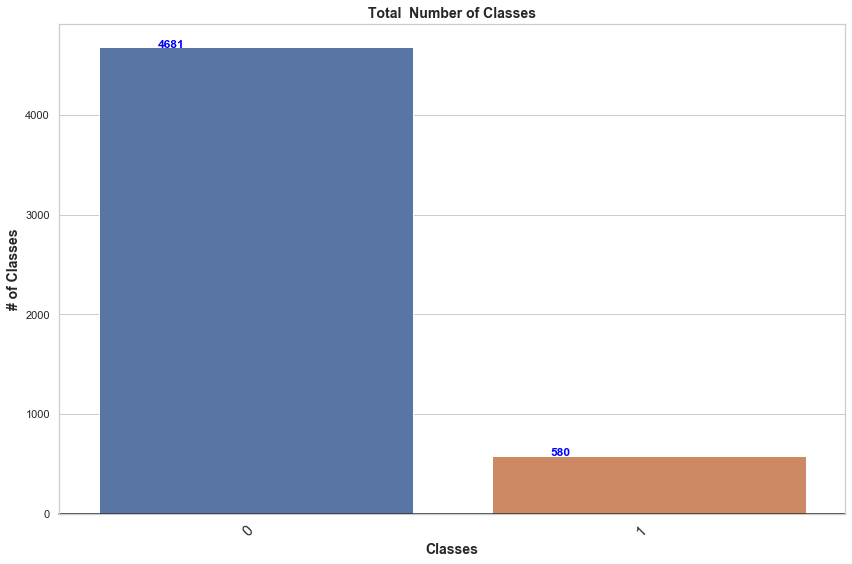

In [124]:
%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})
draw_col_shape(df_prediction,var_to_predict)

In [125]:
# Balance class Up Sampling
# As there is only 580 members that are using the mortgage service.
# Will upsample the 580 (yes) to 4681
# Evaluate imbalanced classification model with different metrics

np.random.seed(42)

# Class count
count_class_0, count_class_1 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over[var_to_predict[0]].value_counts())

draw_col_shape(df_test_over,var_to_predict)
plt.show()

Random over-sampling:
1    4681
0    4681
Name: aaa_credit_card, dtype: int64


Random down-sampling:
1    580
0    580
Name: aaa_credit_card, dtype: int64


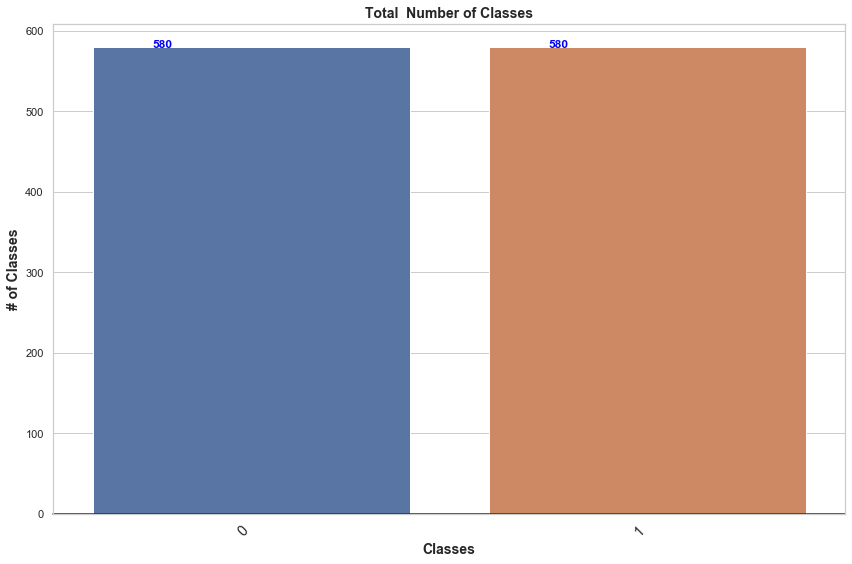

In [126]:
# Downsample Majority Class To Match Minority Class
# Indicies of each class' observations
np.random.seed(42)
count_class_0, count_class_1 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]

df_class_0_down = df_class_0.sample(count_class_1, replace=True)
df_test_down = pd.concat([df_class_1, df_class_0_down], axis=0)

print('Random down-sampling:')
print(df_test_down[var_to_predict[0]].value_counts())

draw_col_shape(df_test_down,var_to_predict)
plt.show()

# Algorithms Search and Testing

In [127]:
df_test_over[df_test_over.isnull().any(axis=1)]

Empty DataFrame
Columns: [total_calls, mean_total_cost, aaa_mean_child, mean_premier_cost, length_of_residence, total_members_in_household, mean_total_calls_veh, mean_tow_miles, consumer_score, total_cost, credit_ranges_800_, credit_ranges_below_700, credit_ranges_between_700___799, education_completed_college, education_high_school, education_some_college, generation_baby_boomers__1948___1968_, generation_generation_x__1969___1980_, generation_generation_z__1994___2010_, generation_millenials__1981___1993_, generation_post_war____1948_, income_100k_, income_40___99999, income_under_39999, aaa_financial_service_0, aaa_financial_service_1, no_members__5___member, no_members_1___member, no_members_2___member, no_members_3___member, no_members_4___member, kcl_b_ind_mosaicsgrouping_boomers, kcl_b_ind_mosaicsgrouping_golden_year, kcl_b_ind_mosaicsgrouping_middle_class_melting_pot, kcl_b_ind_mosaicsgrouping_power_elite, kcl_b_ind_mosaicsgrouping_singles_and_starters, aaa_auto_insurance_0, aaa_auto_insurance_1, aaa_id_theft_0, aaa_id_theft_1, aaa_travel_0, aaa_travel_1, occupation_group_management, occupation_group_other, occupation_group_professional, occupation_group_retired, mosaic_global_household_bourgeois_prosperity, mosaic_global_household_career_and_family, mosaic_global_household_comfortable_retirement, mosaic_global_household_hard_working_blue_collar, mosaic_global_household_low_income_elders, mosaic_global_household_routine_service_workers, use_road_side_0, use_road_side_1, aaa_credit_card]
Index: []

Credit Card Services - Algorithm Comparison - Over Sampling
LR: Accuracy : 0.619058 - Std. Dev.: (0.018054)
LDA: Accuracy : 0.619716 - Std. Dev.: (0.018606)
KNN: Accuracy : 0.781264 - Std. Dev.: (0.015640)
CART: Accuracy : 0.904848 - Std. Dev.: (0.012608)
NB: Accuracy : 0.554970 - Std. Dev.: (0.036241)
SVM: Accuracy : 0.636153 - Std. Dev.: (0.016875)
SGD: Accuracy : 0.609033 - Std. Dev.: (0.020689)
AB: Accuracy : 0.654721 - Std. Dev.: (0.017069)
GBM: Accuracy : 0.721768 - Std. Dev.: (0.019767)
RF: Accuracy : 0.952670 - Std. Dev.: (0.010545)
ET: Accuracy : 0.966148 - Std. Dev.: (0.007642)
XGB: Accuracy : 0.711581 - Std. Dev.: (0.023664)


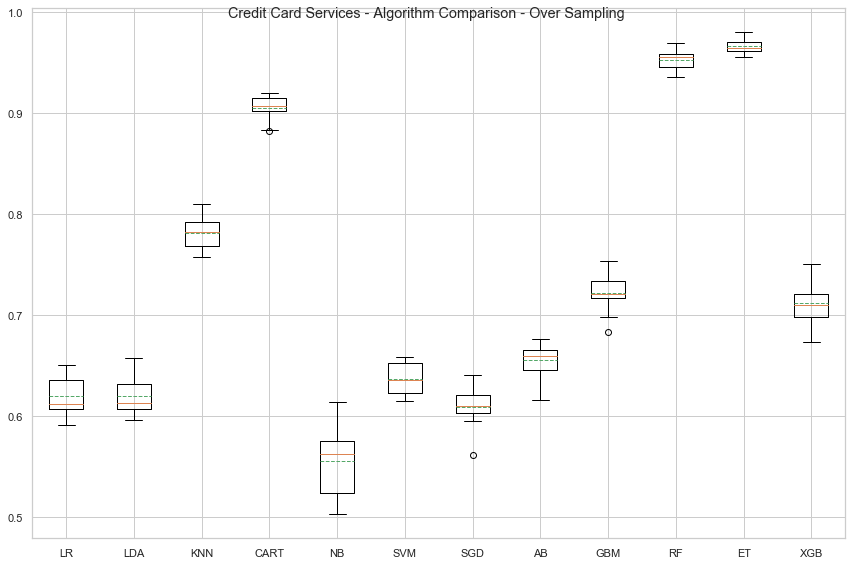

In [128]:
# Algorithms Search
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.35

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)
# Spot Check Algorithms
print(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_algorithms')
plt.show()

Credit Card Services - Algorithm Comparison - Down Sampling
LR: Accuracy : 0.613930 - Std. Dev.: (0.051482)
LDA: Accuracy : 0.612596 - Std. Dev.: (0.052508)
KNN: Accuracy : 0.583702 - Std. Dev.: (0.047553)
CART: Accuracy : 0.575491 - Std. Dev.: (0.059710)
NB: Accuracy : 0.573175 - Std. Dev.: (0.048926)
SVM: Accuracy : 0.608789 - Std. Dev.: (0.046664)
SGD: Accuracy : 0.598018 - Std. Dev.: (0.040296)
AB: Accuracy : 0.623123 - Std. Dev.: (0.047763)
GBM: Accuracy : 0.595474 - Std. Dev.: (0.038697)
RF: Accuracy : 0.591509 - Std. Dev.: (0.039074)
ET: Accuracy : 0.596667 - Std. Dev.: (0.044872)
XGB: Accuracy : 0.580860 - Std. Dev.: (0.030861)


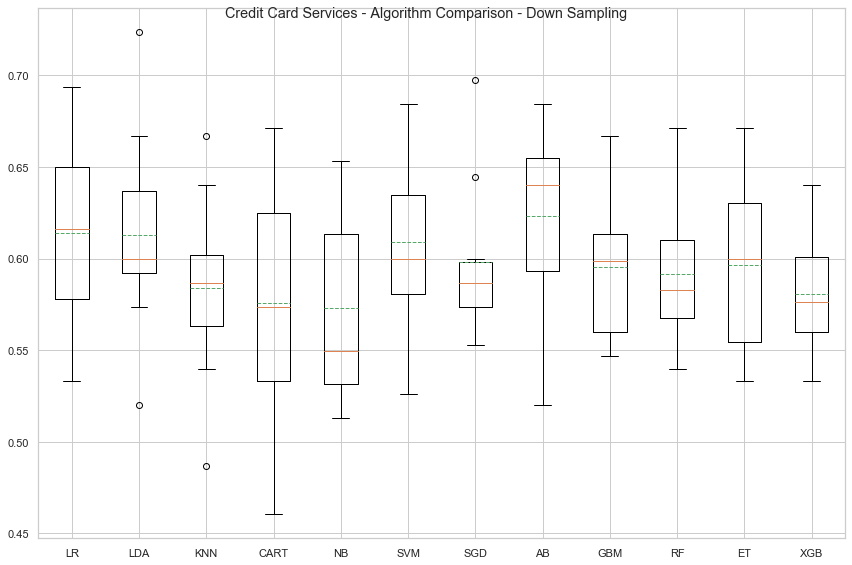

In [129]:
# Algorithms Search Down Sampling the majority class
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'

# Create input and output dataframes
X_df = pd.DataFrame(df_test_down,columns=X_cols)
y_df = pd.DataFrame(df_test_down,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)
# Spot Check Algorithms
print(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_algorithms_down')
plt.show()

# Observation
Based on the previous graph, the model performs better by up sampling the minority class.  the rest of the analysis will be performed using the up sampling data.

* Credit Card Services - Algorithm Comparison - Over Sampling
    * LR: Accuracy : 0.619058 - Std. Dev.: (0.018054)
    * LDA: Accuracy : 0.619716 - Std. Dev.: (0.018606)
    * KNN: Accuracy : 0.781264 - Std. Dev.: (0.015640)
    * CART: Accuracy : 0.904848 - Std. Dev.: (0.012608)
    * NB: Accuracy : 0.554970 - Std. Dev.: (0.036241)
    * SVM: Accuracy : 0.636153 - Std. Dev.: (0.016875)
    * SGD: Accuracy : 0.609033 - Std. Dev.: (0.020689)
    * AB: Accuracy : 0.654721 - Std. Dev.: (0.017069)
    * GBM: Accuracy : 0.721768 - Std. Dev.: (0.019767)
    * RF: Accuracy : 0.952670 - Std. Dev.: (0.010545)
    * ET: Accuracy : 0.966148 - Std. Dev.: (0.007642)
    * XGB: Accuracy : 0.711581 - Std. Dev.: (0.023664)

* Credit Card Services - Algorithm Comparison - Down Sampling
    * LR: Accuracy : 0.613930 - Std. Dev.: (0.051482)
    * LDA: Accuracy : 0.612596 - Std. Dev.: (0.052508)
    * KNN: Accuracy : 0.583702 - Std. Dev.: (0.047553)
    * CART: Accuracy : 0.575491 - Std. Dev.: (0.059710)
    * NB: Accuracy : 0.573175 - Std. Dev.: (0.048926)
    * SVM: Accuracy : 0.608789 - Std. Dev.: (0.046664)
    * SGD: Accuracy : 0.598018 - Std. Dev.: (0.040296)
    * AB: Accuracy : 0.623123 - Std. Dev.: (0.047763)
    * GBM: Accuracy : 0.595474 - Std. Dev.: (0.038697)
    * RF: Accuracy : 0.591509 - Std. Dev.: (0.039074)
    * ET: Accuracy : 0.596667 - Std. Dev.: (0.044872)
    * XGB: Accuracy : 0.580860 - Std. Dev.: (0.030861)

In [131]:
np.random.seed(42)

num_folds = 10
scoring = 'accuracy'
test_size = 0.35

X_df = pd.DataFrame(df_test_over,columns=X_cols,index=df_test_over.index)
y_df = pd.DataFrame(df_test_over,columns=y_cols, index=df_test_over.index)

scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols, index=X_df.index)

trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# Grid Search Logistic Regression

In [133]:
# Grid Search with Up Sampling
# Logistic regression
np.random.seed(42)
num_folds = 10

logregpipe = Pipeline([('logreg',LogisticRegression(penalty='l2',multi_class="auto"))])

# Grid search to determine the value of C and solver
param_grid = {'logreg__C':np.arange(70,90,1), 'logreg__solver':['lbfgs','liblinear','newton-cg']}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=num_folds,return_train_score=True, scoring=scoring)
logreg_cv.fit(trainX, trainy)
print('Logistic regression - Over Sampling the minority class')
print('Logistic Regression - Best Parameters        : ', logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(trainX,trainy)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
print('Logistic Regression - Accuracy Training Data : %.3f' % bestlogreg.score(trainX,trainy))
print('Logistic Regression - Accuracy Test Data     : %.3f' % bestlogreg.score(testX,testy))

Logistic regression - Over Sampling the minority class
Logistic Regression - Best Parameters        :  {'logreg__C': 79, 'logreg__solver': 'lbfgs'}
Logistic Regression - Accuracy Training Data : 0.629
Logistic Regression - Accuracy Test Data     : 0.631


# Observation
Based on the analysis above. It is better to over sample the minority class and these are the best parameters:

First run start C 0.01 to 100 increment of 10
* Logistic regression - Over Sampling the minority class
* Logistic Regression - Best Parameters        :  {'logreg__C': 80.01, 'logreg__solver': 'lbfgs'}
* Logistic Regression - Accuracy Training Data : 0.629
* Logistic Regression - Accuracy Test Data     : 0.630

Based on the previous results shown above, 2nd Run setting C from 30 to 50 in increment of 1 to identify better the parameter
* Logistic regression - Over Sampling the minority class
* Logistic Regression - Best Parameters        :  {'logreg__C': 79, 'logreg__solver': 'lbfgs'}
* Logistic Regression - Accuracy Training Data : 0.629
* Logistic Regression - Accuracy Test Data     : 0.631

Logistic Regression - Accuracy training          : 0.629
Logistic Regression - Accuracy test              : 0.631
Logistic Regression - Precision                  : 0.629
Logistic Regression - Recall                     : 0.613
Logistic Regression - F-measure                  : 0.621
Logistic Regression - Log-Loss                   : 12.743
Logistic Regression - Cross Entropy Loss         : 2.196
Logistic Regression - No Skill - ROC AUC         : 0.500
Logistic Regression - ROC AUC                    : 0.687
Logistic Regression - Cross Validation Accuracy  : 0.628 (+/- 0.050)


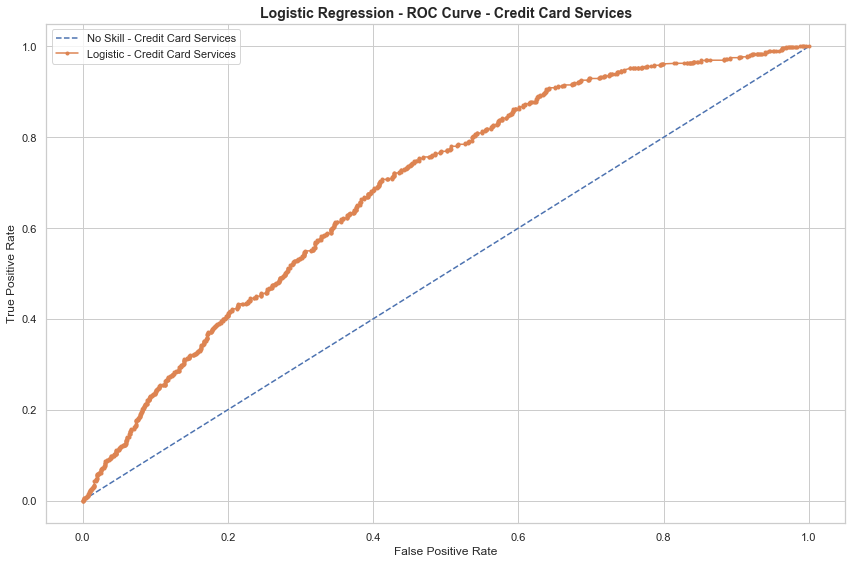

In [134]:
# Use Logistic Regression algorithms to classify which customers are going to use Deposit Service or not (0 = No, 1 = Yes)
# Using Oversample Dataframe with transformation MinMax Scaler

np.random.seed(42)
# Define the model
lr = LogisticRegression(penalty='l2',multi_class="auto", solver="lbfgs", C=79)

# Fit model
lr.fit(trainX, trainy)

# Predict on test set
yhat = lr.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = lr.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
lr_scores = cross_val_score(lr, testX, testy, cv=5)

# Evaluate predictions
print('Logistic Regression - Accuracy training          : %.3f' % accuracy_score(lr.predict(trainX), trainy))
print('Logistic Regression - Accuracy test              : %.3f' % accuracy_score(testy, yhat))
print('Logistic Regression - Precision                  : %.3f' % precision_score(testy, yhat))
print('Logistic Regression - Recall                     : %.3f' % recall_score(testy, yhat))
print('Logistic Regression - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Logistic Regression - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Logistic Regression - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Logistic Regression - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic Regression - ROC AUC                    : %.3f' % (lr_auc))
print('Logistic Regression - Cross Validation Accuracy  : %0.3f (+/- %0.3f)' % (lr_scores.mean(), lr_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('Logistic Regression - ROC Curve - '+var_to_predict_title, loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_lr_roc')
plt.show()

Confusion matrix - Credit Card Services, without normalization - Logistic Regression
[[1078  584]
 [ 625  990]]


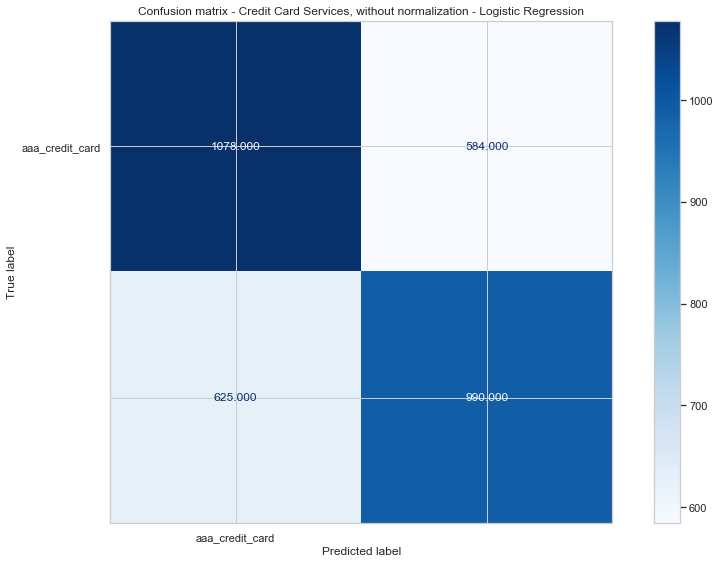

Normalized confusion matrix - Credit Card Services - Logistic Regression
[[0.65 0.35]
 [0.39 0.61]]


In [135]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Logistic Regression", None),
                  ("Normalized confusion matrix - "+var_to_predict_title + " - Logistic Regression", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_lr_cm')
    else: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_lr_cm_1')
    i +=1
    plt.show()

In [136]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': lr.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts_df_lgr = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts_df_lgr.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_df_lgr, height_constant=30, index=False)
fig.write_image('./model_pics/credit_card/'+var_to_predict_save+'_lr_coef.png')
py.iplot(fig)

In [137]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Logistic Regression Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_df_lgr['Features (MinMax Transformer)'], x=counts_df_lgr['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_lr_coef_1')
plt.show()

# k-Nearest Neighbors

In [138]:
# KNN Model - Grid search

np.random.seed(42)
num_folds = 10

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 10)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(trainX, trainy)
    # record training set accuracy
    training_accuracy.append(knn.score(trainX, trainy))
    # record test set accuracy
    test_accuracy.append(knn.score(testX, testy))

plt.plot(neighbors_settings, training_accuracy, label="Training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
# Show title
plt.title('KNN Neighbors Grid Search - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_knn_compare_model')
plt.show()

# Observations
The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the training accuracy drops, indicating that using the single nearest neighbor leads to a model that is too complex.

The best performance is somewhere around one neighbors. Still, it is good to keep the scale of the plot in mind. The worst performance is more than 82% accuracy, which might still be pretty good.

The above plot suggests that we should shoose n_neighbors=1. 

Accuracy of K-NN classifier on training set: 0.987
Accuracy of K-NN classifier on test set    : 0.922
K-NN classifier - Precision                  : 0.872
K-NN classifier - Recall                     : 0.985
K-NN classifier - F-measure                  : 0.925
K-NN classifier - Log-Loss                   : 2.709
K-NN Classifier - Cross Entropy Loss         : 0.084
K-NN classifier - No Skill - ROC AUC         : 0.500
K-NN classifier - ROC AUC                    : 0.922
K-NN classifier - Cross Validation Accuracy  : 0.857 (+/- 0.017)


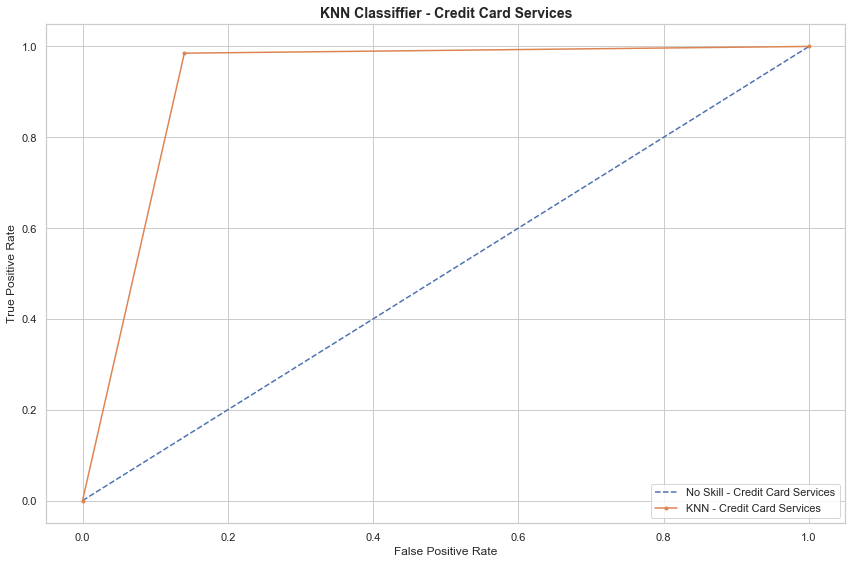

In [139]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(trainX, trainy)


print('Accuracy of K-NN classifier on training set: {:.3f}'.format(knn.score(trainX, trainy)))
print('Accuracy of K-NN classifier on test set    : {:.3f}'.format(knn.score(testX, testy)))

# Predict on test set
yhat = knn.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
knn_probs = knn.predict_proba(testX)

# Keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
knn_auc = roc_auc_score(testy, knn_probs)

# Calculate Cross valdation scores
knn_scores = cross_val_score(knn, testX, testy, cv=num_folds)

# Evaluate predictions
print('K-NN classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('K-NN classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('K-NN classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('K-NN classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('K-NN Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('K-NN classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('K-NN classifier - ROC AUC                    : %.3f' % (knn_auc))
print("K-NN classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (knn_scores.mean(), knn_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(testy, knn_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('KNN Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_knn_roc')
plt.show()

Confusion matrix - Credit Card Services, without normalization - KNN Classiffier
[[1429  233]
 [  24 1591]]


Normalized confusion matrix - Credit Card Services - KNN Classiffier
[[0.86 0.14]
 [0.01 0.99]]


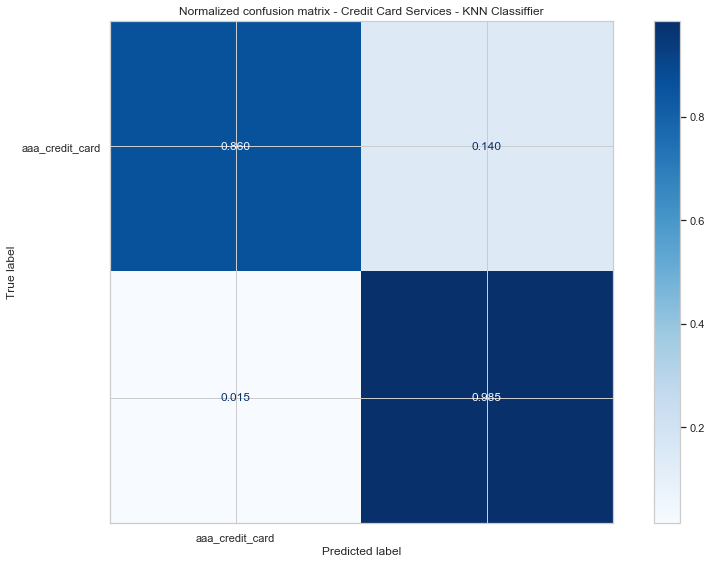

In [140]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - KNN Classiffier", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - KNN Classiffier", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_knn_cm')
    else: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_knn_cm_1')
    i +=1
    plt.show()

# CART  Model - DecisionTreeClassifier

In [142]:
# DecisionTreeClasifier
np.random.seed(42)
num_folds = 10
scoring = 'accuracy'

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(30, 55, 10)}

# decision tree model
cart = DecisionTreeClassifier()

#use gridsearch to test all values
cart_gscv = GridSearchCV(cart, param_grid, cv=num_folds)

#fit model to data
cart_gscv.fit(trainX, trainy)
print('Best parameters : ', cart_gscv.best_params_)
print('Best Score      : ', cart_gscv.best_score_)

Best parameters :  {'criterion': 'gini', 'max_depth': 50}
Best Score      :  0.9051761947973382


# Observation

Based on the grid search above, the best parameter for the Decission Tree Classifier is:
* The 1st run showed a max_depth of 102, with entropy, as i am using an increment of 10, rerun it, using increment of 1 from +-10
* 1st run
    * Best parameters :  {'criterion': 'gini', 'max_depth': 42}
    * Best Score      :  0.9068198513525191
* 2nd run
    * Best parameters :  {'criterion': 'gini', 'max_depth': 50}
    * Best Score      :  0.9051761947973382

CART - Accuracy on training set: 0.991
CART - Accuracy on test set: 0.910
CART - Precision                  : 0.856
CART - Recall                     : 0.983
CART - F-measure                  : 0.915
CART - Log-Loss                   : 3.109
CART - Cross Entropy Loss         : 0.098
CART - No Skill - ROC AUC         : 0.500
CART - ROC AUC                    : 0.919
CART - Cross Validation Accuracy  : 0.837 (+/- 0.036)


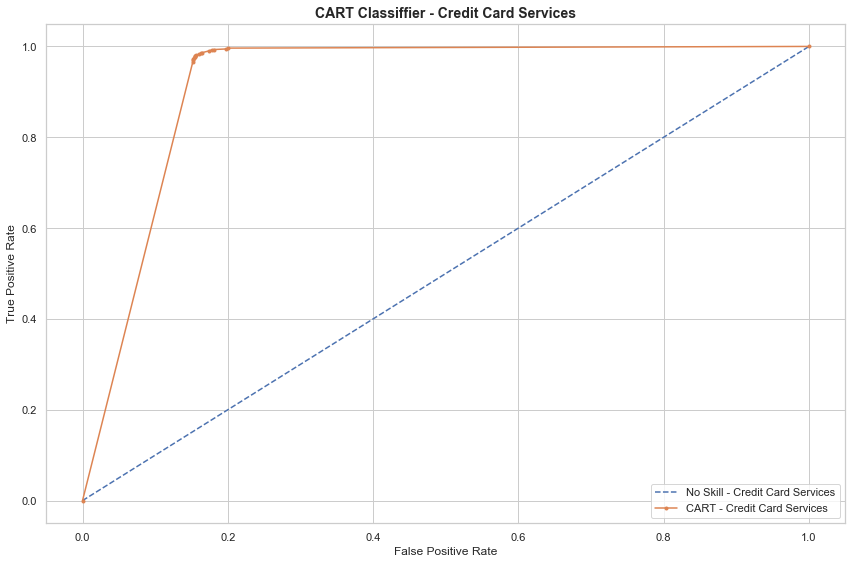

In [148]:
# Modeling based on the outcome of the grid serach
cart = DecisionTreeClassifier(criterion = 'gini', max_depth=42)
cart.fit(trainX, trainy)

# Predict on test set
yhat = cart.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
cart_probs = cart.predict_proba(testX)

# Keep probabilities for the positive outcome only
cart_probs = cart_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
cart_auc = roc_auc_score(testy, cart_probs)

# Calculate Cross valdation scores
cart_scores = cross_val_score(cart, testX, testy, cv=num_folds)

print("CART - Accuracy on training set: {:.3f}".format(cart.score(trainX, trainy)))
print("CART - Accuracy on test set: {:.3f}".format(cart.score(testX, testy)))

# Evaluate predictions
print('CART - Precision                  : %.3f' % precision_score(testy, yhat))
print('CART - Recall                     : %.3f' % recall_score(testy, yhat))
print('CART - F-measure                  : %.3f' % f1_score(testy, yhat))
print('CART - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('CART - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('CART - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('CART - ROC AUC                    : %.3f' % (cart_auc))
print("CART - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (cart_scores.mean(), cart_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
cart_fpr, cart_tpr, _ = roc_curve(testy, cart_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(cart_fpr, cart_tpr, marker='.', label='CART - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('CART Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_cart_roc')
# show the plot
plt.show()

Confusion matrix - Credit Card Services, without normalization - CART
[[1395  267]
 [  28 1587]]


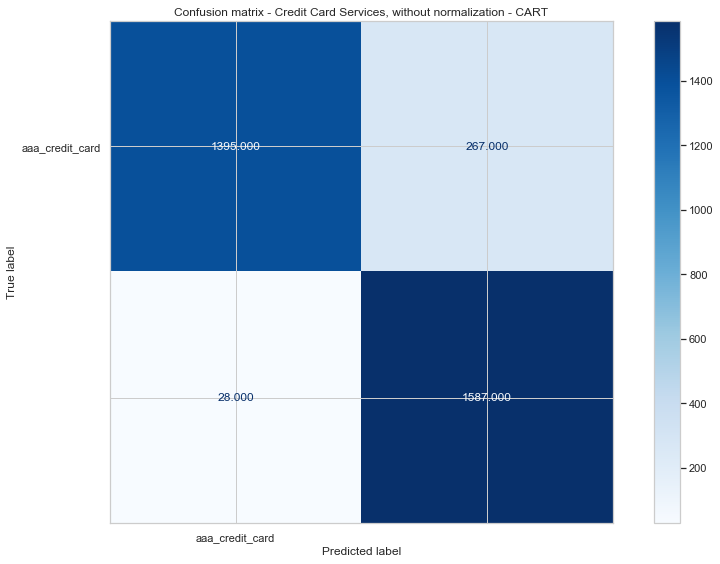

CART - Normalized confusion matrix - Credit Card Services
[[0.84 0.16]
 [0.02 0.98]]


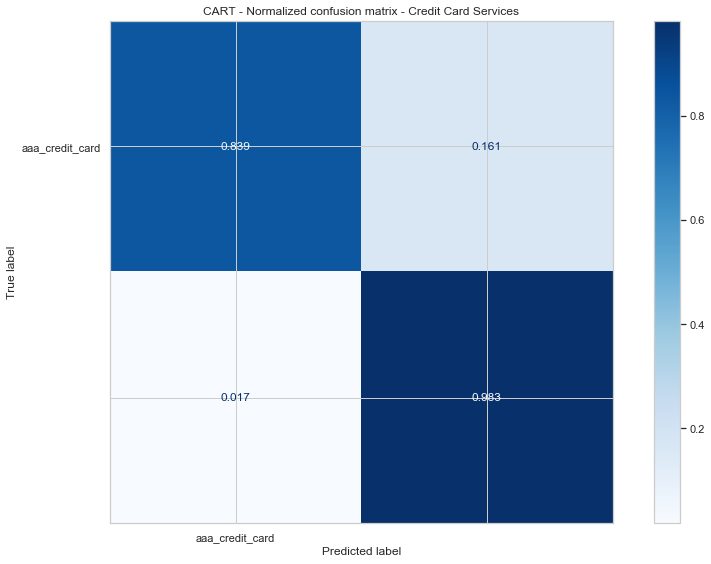

In [149]:
# Confusion Metrics
np.set_printoptions(precision=2)

i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - CART", None),
                  ("CART - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cart, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

    if i==1: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_cart_cm')
    else: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_cart_cm_1')
    i +=1
    plt.show()

# Feature importance in trees
feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [150]:
coef_df_cart = pd.DataFrame({'feature':testX.columns, 'coefs': cart.feature_importances_})
coef_df_cart["abs_coeff"] = coef_df_cart['coefs'].abs()
coef_df_cart.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_cart.nlargest(30,columns=["abs_coeff"])
counts_cart = pd.DataFrame(coef_df_cart.nlargest(30,columns=["abs_coeff"]), index=None)
counts_cart.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_cart, height_constant=30, index=False)
fig.write_image('./model_pics/credit_card/'+var_to_predict_save+'_cart_coef.png')
py.iplot(fig)

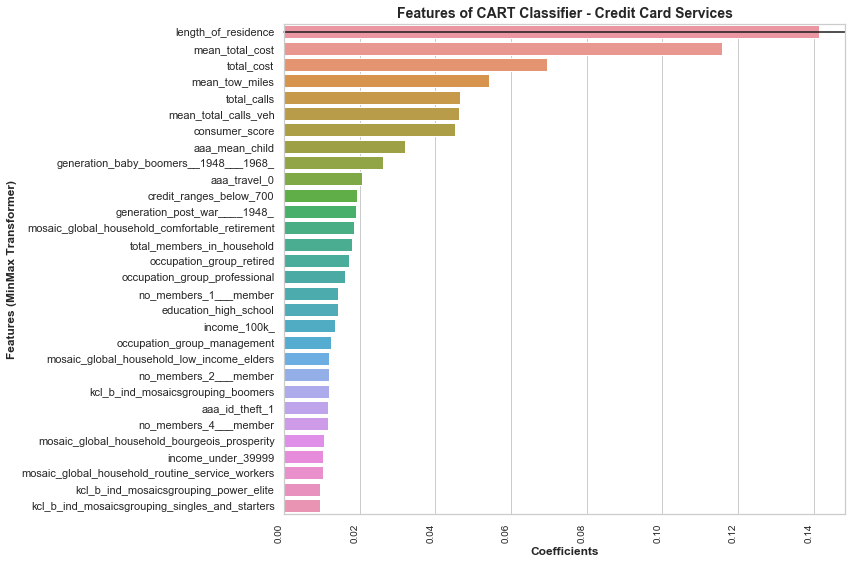

In [151]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of CART Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_cart['Features (MinMax Transformer)'], x=counts_cart['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_cart_coef_1')
plt.show()

# Random Forest Classifier Model

In [152]:
np.random.seed(42)
num_folds = 10
scoring = 'accuracy'

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 125, 10), 'max_features':['auto']}

# Random Forest Classifier model
rf = RandomForestClassifier()

#use gridsearch to test all values
rf_gscv = GridSearchCV(rf, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
rf_gscv.fit(trainX, trainy)
print('Best parameters : ', rf_gscv.best_params_)
print('Best score      : ', rf_gscv.best_score_)

Best parameters :  {'criterion': 'entropy', 'max_depth': 122, 'max_features': 'auto'}
Best score      :  0.9684488700198773


# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run 
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 122, 'max_features': 'auto'}
    * Best score      :  0.9684488700198773

Random Forest - Accuracy on training set: 0.991
Random Forest - Accuracy on test set: 0.910
Random Forest - Precision                  : 0.856
Random Forest - Recall                     : 0.983
Random Forest - F-measure                  : 0.915
Random Forest - Log-Loss                   : 3.120
Random Forest - Cross Entropy Loss         : 0.098
Random Forest - No Skill - ROC AUC         : 0.500
Random Forest - ROC AUC                    : 0.920
Random Forest - Cross Validation Accuracy  : 0.841 (+/- 0.051)


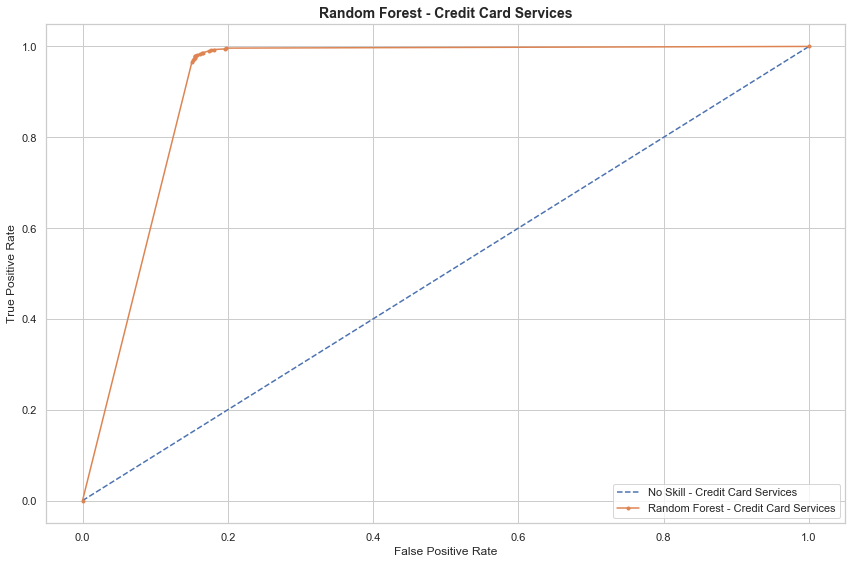

In [153]:
# Modeling based on the outcome of the grid serach of the random forest
rf = RandomForestClassifier(criterion = 'entropy', max_depth=122, max_features='auto')
rf.fit(trainX, trainy)


# Predict on test set
yhat = rf.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
rf_probs = rf.predict_proba(testX)

# Keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
rf_auc = roc_auc_score(testy, rf_probs)

# Calculate Cross valdation scores
rf_scores = cross_val_score(rf, testX, testy, cv=num_folds)

print("Random Forest - Accuracy on training set: {:.3f}".format(rf.score(trainX, trainy)))
print("Random Forest - Accuracy on test set: {:.3f}".format(rf.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Random Forest - Precision                  : %.3f' % precision_score(testy, yhat))
print('Random Forest - Recall                     : %.3f' % recall_score(testy, yhat))
print('Random Forest - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Random Forest - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Random Forest - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Random Forest - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Random Forest - ROC AUC                    : %.3f' % (rf_auc))
print("Random Forest - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(testy, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Random Forest - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_rf_roc')
plt.show()

Confusion matrix - Credit Card Services, without normalization - Random Forest
[[1394  268]
 [  28 1587]]


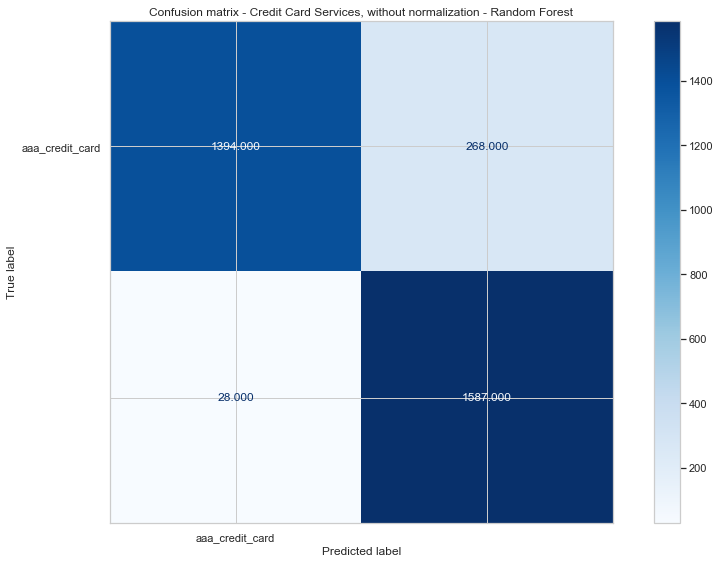

Normalized confusion matrix - Credit Card Services - Random Forest
[[0.84 0.16]
 [0.02 0.98]]


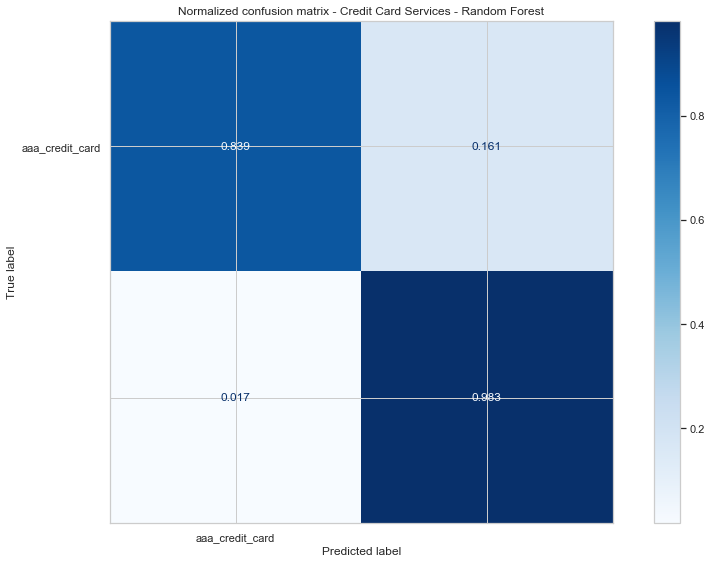

In [154]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1 
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+ ", without normalization - Random Forest", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - Random Forest", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_rf_cm')
    else: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_rf_cm_1')
    i +=1
    plt.show()

# Feature importance
feature importance rates how important each feature is for the random forest tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [155]:
coef_df_rf = pd.DataFrame({'feature':testX.columns, 'coefs': rf.feature_importances_})
coef_df_rf["abs_coeff"] = coef_df_rf['coefs'].abs()
coef_df_rf.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_rf.nlargest(30,columns=["abs_coeff"])
counts_rf = pd.DataFrame(coef_df_rf.nlargest(30,columns=["abs_coeff"]), index=None)
counts_rf.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_rf, height_constant=30, index=False)
fig.write_image('./model_pics/credit_card/'+var_to_predict_save+'_rf_coef.png')
py.iplot(fig)

In [156]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Random Forest Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_rf['Features (MinMax Transformer)'], x=counts_rf['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_rf_coef_1')
plt.show()

# ExtraTreesClassifier Classifier

In [159]:
np.random.seed(42)
# Create input and output dataframes
num_folds = 10
scoring = 'accuracy'

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(50, 75,1)}

# Random Forest Classifier model
et = ExtraTreesClassifier()

#use gridsearch to test all values
et_gscv = GridSearchCV(et, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
et_gscv.fit(trainX, trainy)
print('Best parameters : ', et_gscv.best_params_)
print('Best score      : ', et_gscv.best_score_)

Best parameters :  {'criterion': 'gini', 'max_depth': 53}
Best score      :  0.9740347636332212


# Observation
Based on the grid search above, th best parameter for the ExtraTree Classifier is:
The 1st run 
    * Best parameters :  {'criterion': 'gini', 'max_depth': 62}
    * Best score      :  0.974034763633221

* Final run
    * Best parameters :  {'criterion': 'gini', 'max_depth': 53}
    * Best score      :  0.9740347636332212

In [160]:
# Modeling based on the outcome of the grid serach of the random forest
et = ExtraTreesClassifier(criterion = 'gini', max_depth=53)
et.fit(trainX, trainy)

# Predict on test set
yhat = et.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
et_probs = et.predict_proba(testX)

# Keep probabilities for the positive outcome only
et_probs = et_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
et_auc = roc_auc_score(testy, et_probs)

# Calculate Cross valdation scores
scores_et = cross_val_score(et, testX, testy, cv=num_folds)

print("Extra Tree Classifier - Accuracy on training set: {:.3f}".format(et.score(trainX, trainy)))
print("Extra Tree Classifier - Accuracy on test set: {:.3f}".format(et.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Extra Tree Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('Extra Tree Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('Extra Tree Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Extra Tree Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Extra Tree Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Extra Tree Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Extra Tree Classifier - ROC AUC                    : %.3f' % (et_auc))
print("Extra Tree Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_et.mean(), scores_et.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
et_fpr, et_tpr, _ = roc_curve(testy, et_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(et_fpr, et_tpr, marker='.', label='Extra Tree Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_roc')
plt.show()

Extra Tree Classifier - Accuracy on training set: 0.991
Extra Tree Classifier - Accuracy on test set: 0.976
Extra Tree Classifier - Precision                  : 0.969
Extra Tree Classifier - Recall                     : 0.983
Extra Tree Classifier - F-measure                  : 0.976
Extra Tree Classifier - Log-Loss                   : 0.822
Extra Tree Classifier - Cross Entropy Loss         : 0.098
Extra Tree Classifier - No Skill - ROC AUC         : 0.500
Extra Tree Classifier - ROC AUC                    : 0.994
Extra Tree Classifier - Cross Validation Accuracy  : 0.914 (+/- 0.032)


In [161]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Extra Tree Classifier", None),
                  ("Extra Tree Classifier - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(et, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_cm')
    else: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_cm_1')
    i +=1
    plt.show()

Confusion matrix - Credit Card Services, without normalization - Extra Tree Classifier
[[1612   50]
 [  28 1587]]


Extra Tree Classifier - Normalized confusion matrix - Credit Card Services
[[0.97 0.03]
 [0.02 0.98]]


In [162]:
coef_df_et = pd.DataFrame({'feature':testX.columns, 'coefs': et.feature_importances_})
coef_df_et["abs_coeff"] = coef_df_et['coefs'].abs()
coef_df_et.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_et.nlargest(30,columns=["abs_coeff"])
counts_et = pd.DataFrame(coef_df_et.nlargest(30,columns=["abs_coeff"]), index=None)
counts_et.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_et, height_constant=30, index=False)
fig.write_image('./model_pics/credit_card/'+var_to_predict_save+'_et_coef.png')
py.iplot(fig)

In [163]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_et['Features (MinMax Transformer)'], x=counts_et['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_coef_1')
plt.show()

# XGBossting Classifier Model

In [164]:
np.random.seed(42)
scoring = 'accuracy'

#create a dictionary of all values we want to test
param_grid = {'max_depth': [3, 4, 5,6,8], 'n_estimators': [100, 200, 500, 1000], 
              'learning_rate': [0.1, 0.05, 0.01] 
             }
# CV model
xgb = XGBClassifier()
kfold = KFold(n_splits=num_folds)
xgb_gscv = GridSearchCV(estimator=xgb,param_grid=param_grid, scoring = scoring, 
                        n_jobs = 10, cv = kfold,verbose=True
                       )
xgb_gscv.fit(trainX, trainy)
print('Best parameters - : ', xgb_gscv.best_params_)
print('Best score      : ', xgb_gscv.best_score_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 26.5min
[Parallel(n_jobs=10)]: Done 600 out of 600 | elapsed: 39.0min finished


Best parameters - :  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}
Best score      :  0.9390310366433324


# Observation
* Best parameters - :  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}
* Best score      :  0.9390310366433324

XGBoost Classifier - Accuracy on training set: 0.991
XGBoost Classifier - Accuracy on test set: 0.946
XGBoost Classifier - Precision                  : 0.915
XGBoost Classifier - Recall                     : 0.983
XGBoost Classifier - F-measure                  : 0.947
XGBoost Classifier - Log-Loss                   : 1.855
XGBoost Classifier - Cross Entropy Loss         : 0.098
XGBoost Classifier - No Skill - ROC AUC         : 0.500
XGBoost Classifier - ROC AUC                    : 0.992
XGBoost Classifier - Cross Validation Accuracy  : 0.870 (+/- 0.029)


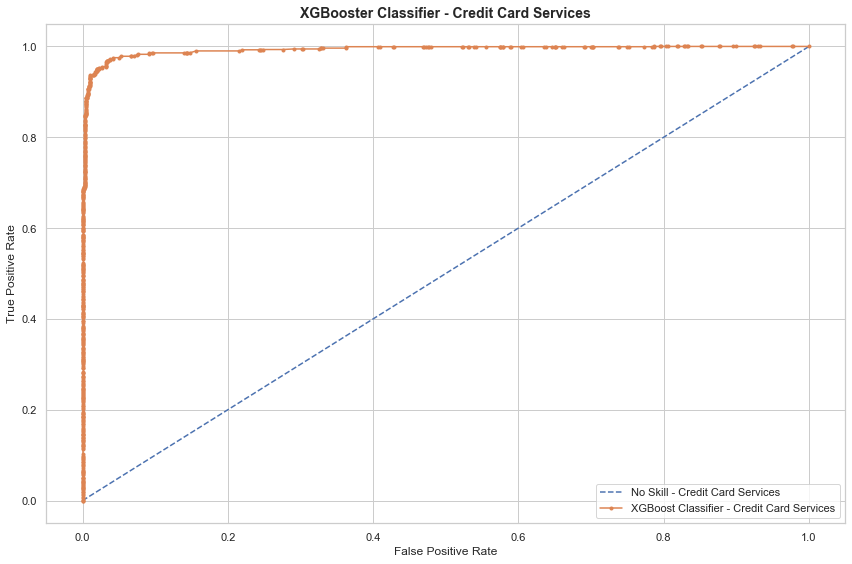

In [165]:
# Modeling based on the outcome of the grid serach of the random forest
xgb = XGBClassifier(learning_rate=0.1, max_depth=8, n_estimators=1000)
xgb.fit(trainX, trainy)

# Predict on test set
yhat = xgb.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
xgb_probs = xgb.predict_proba(testX)

# Keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
xgb_auc = roc_auc_score(testy, xgb_probs)

# Calculate Cross valdation scores
scores_xgb = cross_val_score(xgb, testX, testy, cv=num_folds)

print("XGBoost Classifier - Accuracy on training set: {:.3f}".format(xgb.score(trainX, trainy)))
print("XGBoost Classifier - Accuracy on test set: {:.3f}".format(xgb.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('XGBoost Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('XGBoost Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('XGBoost Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('XGBoost Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('XGBoost Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('XGBoost Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('XGBoost Classifier - ROC AUC                    : %.3f' % (xgb_auc))
print("XGBoost Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(testy, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_xgb_roc')
plt.show()

Confusion matrix - Credit Card Services, without normalization - XGBoost Classifier
[[1514  148]
 [  28 1587]]


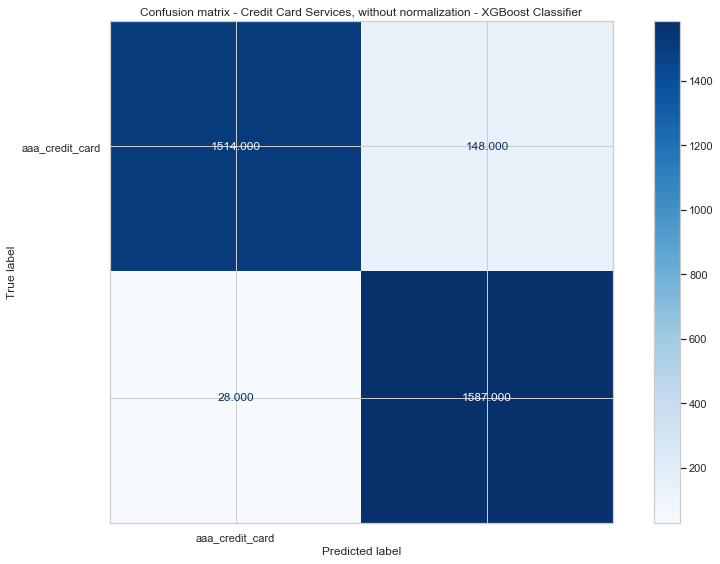

XGBoost Classifier - Normalized confusion matrix - Credit Card Services
[[0.91 0.09]
 [0.02 0.98]]


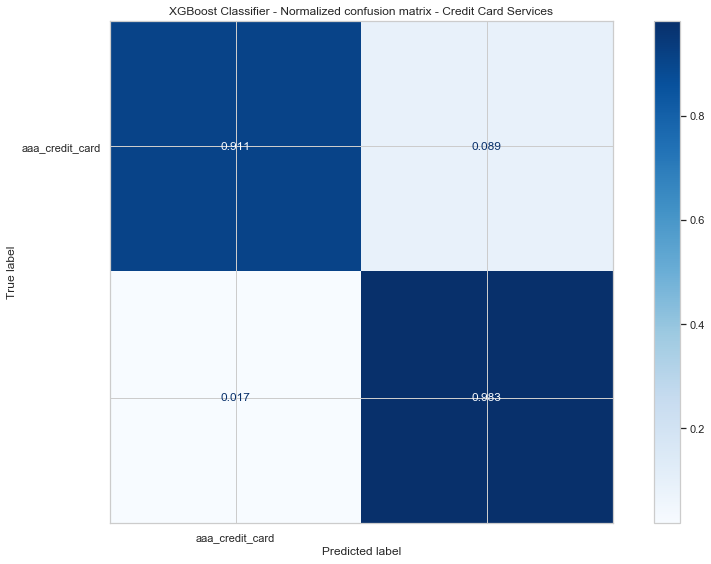

In [166]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - XGBoost Classifier", None),
                  ("XGBoost Classifier - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgb, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_xgb_cm')
    else: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_xgb_cm_1')
    i +=1
    plt.show()

In [167]:
coef_df_xgb = pd.DataFrame({'feature':testX.columns, 'coefs': xgb.feature_importances_})
coef_df_xgb["abs_coeff"] = coef_df_xgb['coefs'].abs()
coef_df_xgb.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_xgb.nlargest(30,columns=["abs_coeff"])
counts_xgb = pd.DataFrame(coef_df_xgb.nlargest(30,columns=["abs_coeff"]), index=None)
counts_xgb.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_xgb, height_constant=30, index=False)
fig.write_image('./model_pics/credit_card/'+var_to_predict_save+'_xgb_coef.png')
py.iplot(fig)

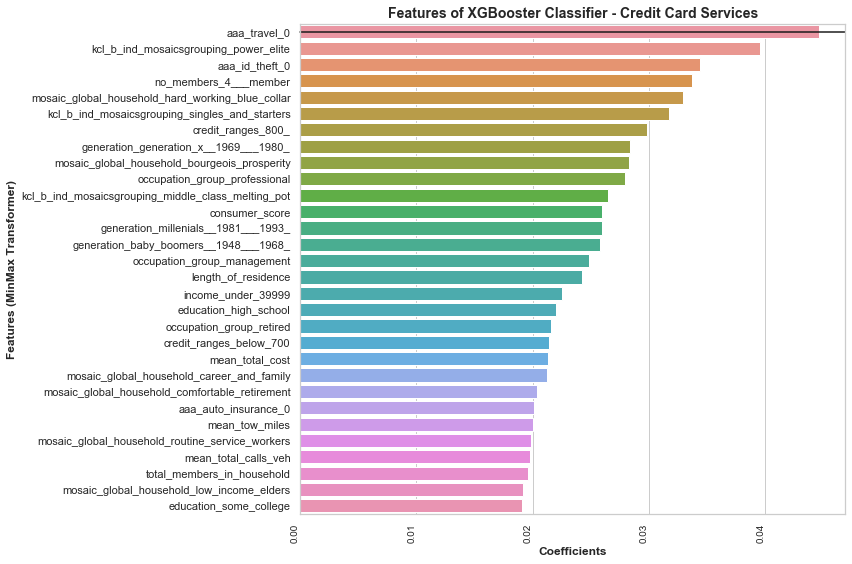

In [168]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_xgb['Features (MinMax Transformer)'], x=counts_xgb['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_xgb_coef_1')
plt.show()

# Model Comparison

* Logistic Regression
    * Logistic Regression - Accuracy training          : 0.629
    * Logistic Regression - Accuracy test              : 0.631
    * Logistic Regression - Precision                  : 0.629
    * Logistic Regression - Recall                     : 0.613
    * Logistic Regression - F-measure                  : 0.621
    * Logistic Regression - Log-Loss                   : 12.743
    * Logistic Regression - Cross Entropy Loss         : 2.196
    * Logistic Regression - No Skill - ROC AUC         : 0.500
    * Logistic Regression - ROC AUC                    : 0.687
    * Logistic Regression - Cross Validation Accuracy  : 0.628 (+/- 0.050)

* K-NN Classifier
    * Accuracy of K-NN classifier on training set: 0.987
    * Accuracy of K-NN classifier on test set    : 0.922
    * K-NN classifier - Precision                  : 0.872
    * K-NN classifier - Recall                     : 0.985
    * K-NN classifier - F-measure                  : 0.925
    * K-NN classifier - Log-Loss                   : 2.709
    * K-NN Classifier - Cross Entropy Loss         : 0.084
    * K-NN classifier - No Skill - ROC AUC         : 0.500
    * K-NN classifier - ROC AUC                    : 0.922
    * K-NN classifier - Cross Validation Accuracy  : 0.857 (+/- 0.017)

* Decision Tree Classifier
    * CART - Accuracy on training set: 0.991
    * CART - Accuracy on test set: 0.910
    * CART - Precision                  : 0.856
    * CART - Recall                     : 0.983
    * CART - F-measure                  : 0.915
    * CART - Log-Loss                   : 3.109
    * CART - Cross Entropy Loss         : 0.098
    * CART - No Skill - ROC AUC         : 0.500
    * CART - ROC AUC                    : 0.919
    * CART - Cross Validation Accuracy  : 0.837 (+/- 0.036)

* Random Forest Classifier
    * Random Forest - Accuracy on training set: 0.991
    * Random Forest - Accuracy on test set: 0.910
    * Random Forest - Precision                  : 0.856
    * Random Forest - Recall                     : 0.983
    * Random Forest - F-measure                  : 0.915
    * Random Forest - Log-Loss                   : 3.120
    * Random Forest - Cross Entropy Loss         : 0.098
    * Random Forest - No Skill - ROC AUC         : 0.500
    * Random Forest - ROC AUC                    : 0.920
    * Random Forest - Cross Validation Accuracy  : 0.841 (+/- 0.051)

* Extra Tree Classifier
    * Extra Tree Classifier - Accuracy on training set: 0.991
    * Extra Tree Classifier - Accuracy on test set: 0.976
    * Extra Tree Classifier - Precision                  : 0.969
    * Extra Tree Classifier - Recall                     : 0.983
    * Extra Tree Classifier - F-measure                  : 0.976
    * Extra Tree Classifier - Log-Loss                   : 0.822
    * Extra Tree Classifier - Cross Entropy Loss         : 0.098
    * Extra Tree Classifier - No Skill - ROC AUC         : 0.500
    * Extra Tree Classifier - ROC AUC                    : 0.994
    * Extra Tree Classifier - Cross Validation Accuracy  : 0.914 (+/- 0.032)

* XGBoost Classifer
    * XGBoost Classifier - Accuracy on training set: 0.991
    * XGBoost Classifier - Accuracy on test set: 0.946
    * XGBoost Classifier - Precision                  : 0.915
    * XGBoost Classifier - Recall                     : 0.983
    * XGBoost Classifier - F-measure                  : 0.947
    * XGBoost Classifier - Log-Loss                   : 1.855
    * XGBoost Classifier - Cross Entropy Loss         : 0.098
    * XGBoost Classifier - No Skill - ROC AUC         : 0.500
    * XGBoost Classifier - ROC AUC                    : 0.992
    * XGBoost Classifier - Cross Validation Accuracy  : 0.870 (+/- 0.029)

# Best two models Extra Tree and XGBoost Classifier

# Select From model - Reduce dimensionality
Reduce the number of features

In [169]:
print("Number of feature before reduction : ",trainX.shape[1])
# Going to use XGBoost model built previously as it has 2nd best accuracy
model = SelectFromModel(xgb, prefit=True)
trainX_svc = model.transform(trainX)
print("Number of feature after reduction : ",trainX_svc.shape[1]) #reduction from 72 to 14 features
feature_idx = model.get_support()
feature_reduced = trainX.columns[feature_idx]
print('Features Selected using XGBoost Classifier')
for i in range(len(feature_reduced)):
    print(i+1, " - ",feature_reduced[i])

Number of feature before reduction :  54
Number of feature after reduction :  30
Features Selected using XGBoost Classifier
1  -  mean_total_cost
2  -  length_of_residence
3  -  total_members_in_household
4  -  mean_total_calls_veh
5  -  mean_tow_miles
6  -  consumer_score
7  -  credit_ranges_800_
8  -  credit_ranges_below_700
9  -  education_high_school
10  -  education_some_college
11  -  generation_baby_boomers__1948___1968_
12  -  generation_generation_x__1969___1980_
13  -  generation_millenials__1981___1993_
14  -  income_under_39999
15  -  no_members_4___member
16  -  kcl_b_ind_mosaicsgrouping_middle_class_melting_pot
17  -  kcl_b_ind_mosaicsgrouping_power_elite
18  -  kcl_b_ind_mosaicsgrouping_singles_and_starters
19  -  aaa_auto_insurance_0
20  -  aaa_id_theft_0
21  -  aaa_travel_0
22  -  occupation_group_management
23  -  occupation_group_professional
24  -  occupation_group_retired
25  -  mosaic_global_household_bourgeois_prosperity
26  -  mosaic_global_household_career_and_

In [170]:
# Modeling using ExtraTreeClassifier with new features
np.random.seed(42)
trainX_reduced = pd.DataFrame(trainX, columns=feature_reduced)
testX_reduced = pd.DataFrame(testX, columns=feature_reduced)

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 125,10)}

# Random Forest Classifier model
et_reduced = ExtraTreesClassifier()

#use gridsearch to test all values
et_gscv_reduced = GridSearchCV(et_reduced, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
et_gscv_reduced.fit(trainX_reduced, trainy)
print('Best parameters : ', et_gscv_reduced.best_params_)
print('Best score      : ', et_gscv_reduced.best_score_)

# Best parameters :  {'criterion': 'gini', 'max_depth': 42}
# Best score      :  0.9615458365741942

Best parameters :  {'criterion': 'gini', 'max_depth': 42}
Best score      :  0.9615458365741942


ExtraTree Classifier with Reduced Features
Extra Tree Classifier - Accuracy on training set   : 0.983
Extra Tree Classifier - Accuracy on test set       : 0.963
Extra Tree Classifier - Precision                  : 0.951
Extra Tree Classifier - Recall                     : 0.976
Extra Tree Classifier - F-measure                  : 0.963
Extra Tree Classifier - Log-Loss                   : 1.265
Extra Tree Classifier - Cross Entropy Loss         : 0.133
Extra Tree Classifier - No Skill - ROC AUC         : 0.500
Extra Tree Classifier - ROC AUC                    : 0.993
Extra Tree Classifier - Cross Validation Accuracy  : 0.902 (+/- 0.029)


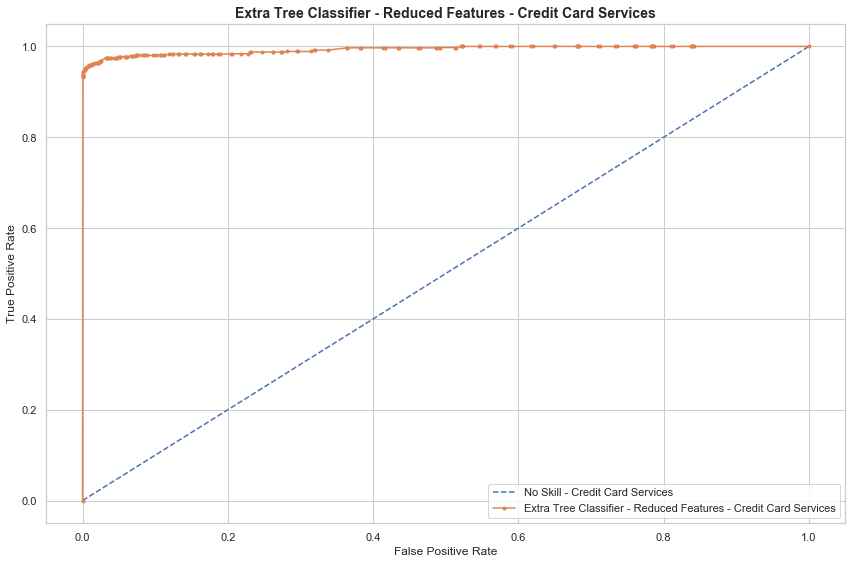

In [171]:
# Modeling based on the outcome of the grid serach of the Extratree Classifier
et_reduced = ExtraTreesClassifier(criterion = 'gini', max_depth=42)
et_reduced.fit(trainX_reduced, trainy)

# Predict on test set
yhat_reduced = et_reduced.predict(testX_reduced)

# Generate a no skill prediction for ROC Curve
ns_probs_reduced = [0 for _ in range(len(testy))]

# Predict probabilities
et_probs_reduced = et_reduced.predict_proba(testX_reduced)

# Keep probabilities for the positive outcome only
et_probs_reduced = et_probs_reduced[:, 1]

# Calculate scores
ns_auc_reduced = roc_auc_score(testy, ns_probs_reduced)
et_auc_reduced = roc_auc_score(testy, et_probs_reduced)

# Calculate Cross valdation scores
scores_et_reduced = cross_val_score(et_reduced, testX_reduced, testy, cv=num_folds)

print('ExtraTree Classifier with Reduced Features')
print("Extra Tree Classifier - Accuracy on training set   : {:.3f}".format(et_reduced.score(trainX_reduced, trainy)))
print("Extra Tree Classifier - Accuracy on test set       : {:.3f}".format(et_reduced.score(testX_reduced, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Extra Tree Classifier - Precision                  : %.3f' % precision_score(testy, yhat_reduced))
print('Extra Tree Classifier - Recall                     : %.3f' % recall_score(testy, yhat_reduced))
print('Extra Tree Classifier - F-measure                  : %.3f' % f1_score(testy, yhat_reduced))
print('Extra Tree Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat_reduced))
print('Extra Tree Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat_reduced, testy[var_to_predict[0]]))
print('Extra Tree Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc_reduced))
print('Extra Tree Classifier - ROC AUC                    : %.3f' % (et_auc_reduced))
print("Extra Tree Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_et_reduced.mean(), 
                                                                                  scores_et_reduced.std() * 2))

# calculate roc curves
ns_fpr_reduced, ns_tpr_reduced, _ = roc_curve(testy, ns_probs_reduced)
et_fpr_reduced, et_tpr_reduced, _ = roc_curve(testy, et_probs_reduced)
# plot the roc curve for the model
plt.plot(ns_fpr_reduced, ns_tpr_reduced, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(et_fpr_reduced, et_tpr_reduced, marker='.', label='Extra Tree Classifier - Reduced Features - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Extra Tree Classifier - Reduced Features - '+var_to_predict_title,loc='center', 
          fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_roc_reduced')
plt.show()

Confusion matrix - Credit Card Services, without normalization - Extra Tree Classifier - Reduced Features
[[1580   82]
 [  38 1577]]


Extra Tree Classifier Reduced Features- Normalized confusion matrix - Credit Card Services
[[0.95 0.05]
 [0.02 0.98]]


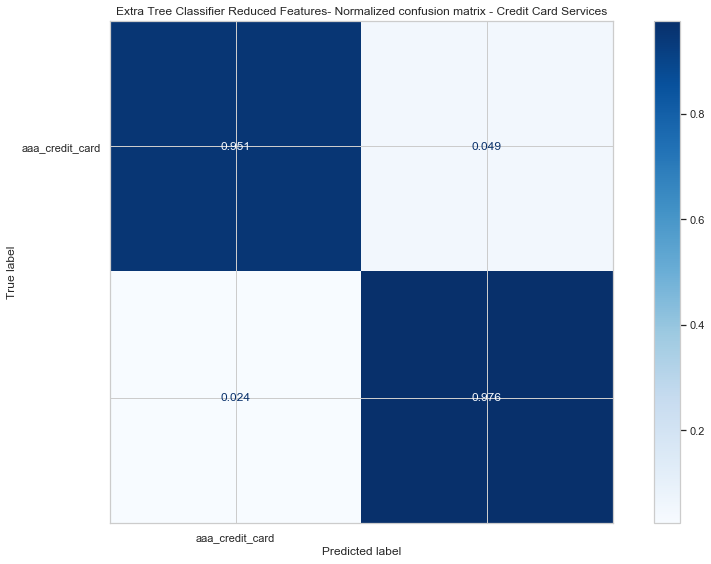

In [172]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Extra Tree Classifier - Reduced Features", None),
                  ("Extra Tree Classifier Reduced Features- Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(et_reduced, testX_reduced, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_cm_reduced')
    else: plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_cm_1_reduced')
    i +=1
    plt.show()

# Gain and Lift charts of the final model

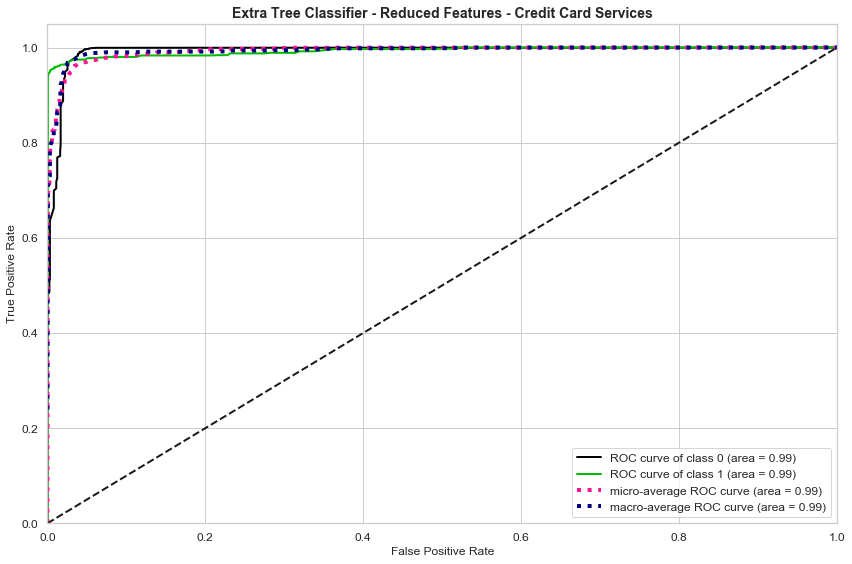

In [173]:
# ROC Chart
import scikitplot as skplt
skplt.metrics.plot_roc(testy, et_reduced.predict_proba(testX_reduced))
plt.title('Extra Tree Classifier - Reduced Features - '+var_to_predict_title,loc='center', 
          fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_roc_reduced_1')
plt.show()

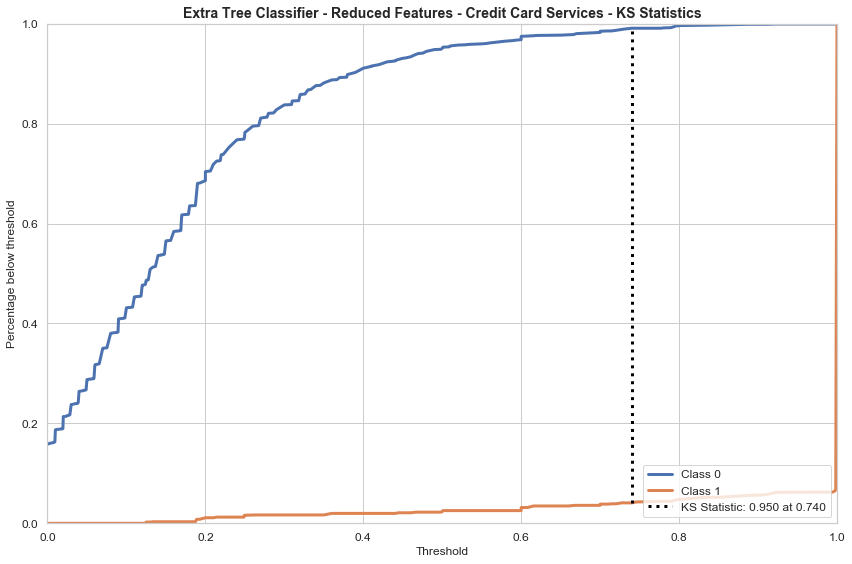

In [174]:
# KS statitics Graph
skplt.metrics.plot_ks_statistic(testy, et_reduced.predict_proba(testX_reduced))
plt.title('Extra Tree Classifier - Reduced Features - '+var_to_predict_title+ ' - KS Statistics',loc='center', 
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_kss_reduced')
plt.show()

In [175]:
# Precision/Recall Graph
skplt.metrics.plot_precision_recall(testy, et_reduced.predict_proba(testX_reduced))
plt.title('Extra Tree Classifier - Reduced Features - '+var_to_predict_title+ ' - Recision/Recall',loc='center', 
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_pr_reduced')
plt.show()

# Cummulative Gain Charts
The cumulative gains chart is used to determine the effectiveness of a binary classifier. A detailed explanation can be found at http://mlwiki.org/index.php/Cumulative_Gain_Chart. The implementation here works only for binary classification.

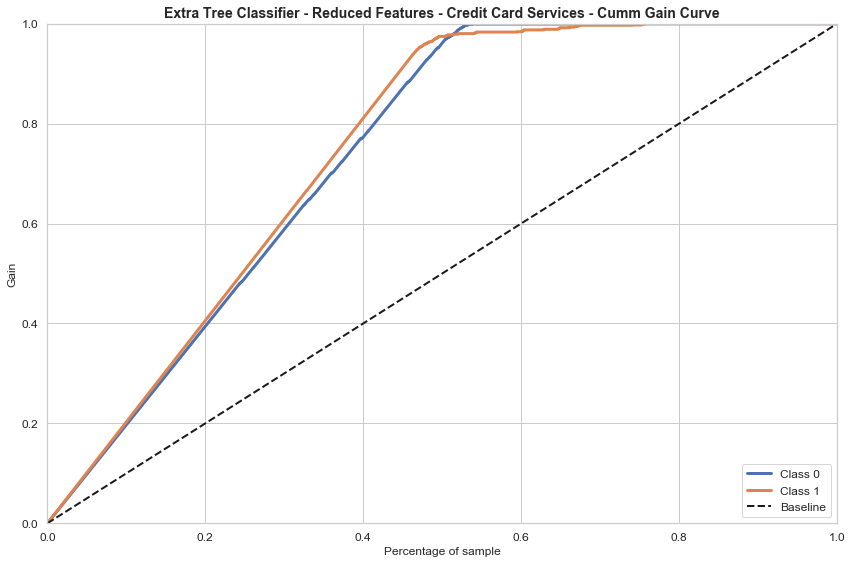

In [176]:
skplt.metrics.plot_cumulative_gain(testy, et_reduced.predict_proba(testX_reduced))
plt.title('Extra Tree Classifier - Reduced Features - '+var_to_predict_title+ ' - Cumm Gain Curve',loc='center', 
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig('./model_pics/credit_card/'+var_to_predict_save+'_et_cumm_reduced')
plt.show()

# Lift Charts
The lift curve is used to determine the effectiveness of a binary classifier. A detailed explanation can be found at http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html.

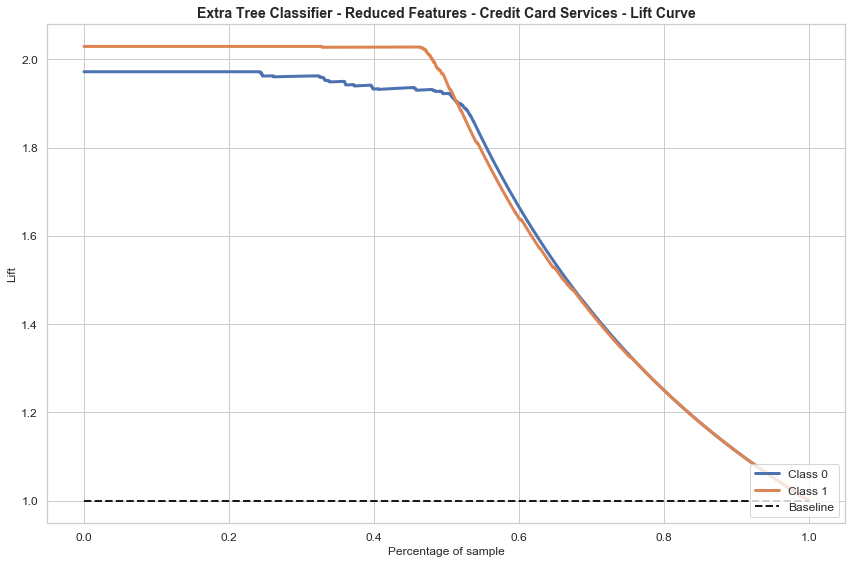

In [177]:
skplt.metrics.plot_lift_curve(testy, et_reduced.predict_proba(testX_reduced))
plt.title('Extra Tree Classifier - Reduced Features - '+var_to_predict_title+ ' - Lift Curve',loc='center', 
          fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig('./model_pics/Auto Insurance/'+var_to_predict_save+'_et_lift_reduced')
plt.show()

•	Join your training and validation sets. Score all the members that do not have the purchase of a product with the probability of purchase.  If they have purchased the product, score them a 1.

In [178]:
# Get the entire dataset and select the proper features
join_df_X = pd.DataFrame(df_prediction, columns=feature_reduced)
et_prob_all = et_reduced.predict_proba(join_df_X)

In [179]:
# Constructing new data Frame
# Actual value of a member to cancel
join_df_X[var_to_predict] = df_household[var_to_predict]
# Get membership ID
join_df_X['membership_id'] = df_household['membership_id']
# Construct Probality data
df_et_prob_all = pd.DataFrame({'no_credit_card': et_prob_all[:, 0], 
                               'yes_credit_card': et_prob_all[:, 1]}, 
                              index=df_household.index
                             )
join_df_X['yes_credit_card'] =  df_et_prob_all['yes_credit_card']
join_df_X['yes_credit_card']=np.where(join_df_X[var_to_predict[0]]== 1, 1, join_df_X['yes_credit_card'])

In [180]:
join_df_X.head(10)

mean_total_cost  length_of_residence  total_members_in_household  mean_total_calls_veh  mean_tow_miles  consumer_score  credit_ranges_800_  credit_ranges_below_700  education_high_school  education_some_college  generation_baby_boomers__1948___1968_  generation_generation_x__1969___1980_  generation_millenials__1981___1993_  income_under_39999  no_members_4___member  kcl_b_ind_mosaicsgrouping_middle_class_melting_pot  kcl_b_ind_mosaicsgrouping_power_elite  kcl_b_ind_mosaicsgrouping_singles_and_starters  aaa_auto_insurance_0  aaa_id_theft_0  aaa_travel_0  occupation_group_management  occupation_group_professional  occupation_group_retired  mosaic_global_household_bourgeois_prosperity  mosaic_global_household_career_and_family  mosaic_global_household_comfortable_retirement  mosaic_global_household_hard_working_blue_collar  mosaic_global_household_low_income_elders  mosaic_global_household_routine_service_workers  aaa_credit_card  membership_id  yes_credit_card
0          33.8333              15.0000                           1                2.5485          0.0889          0.0137                   0                        1                      0                       1                                      0                                      0                                    0                   1                      0                                                  0                                       0                                               0                     1               1             1                            0                              0                         0                                             0                                          0                                               0                                                 0                                          1                                                0                1            153           1.0000
1           0.0000               0.0000                           1                0.1645          0.0000          0.0149                   0                        0                      0                       0                                      0                                      0                                    0                   0                      0                                                  0                                       0                                               0                     1               1             1                            0                              0                         0                                             0                                          0                                               1                                                 0                                          0                                                0                0            155           0.4200
2          39.2056               8.5556                           4                2.3971          0.0000          0.0123                   0                        0                      0                       0                                      0                                      0                                    1                   0                      1                                                  0                                       0                                               0                     1               1             1                            0                              0                         0                                             0                                          0                                               0                                                 0                                          0                                                1                0            163           0.0600
3          28.0000              15.0000                           1                3.7444      

In [181]:
# Save all Data and final models
filename = './save_models/'+var_to_predict_save+'_finalized_model_et.sav'
pickle.dump(et_reduced, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(testX_reduced, testy)
print(result)

filename = var_to_predict_save+'_reduced_feature_outcome.csv'
save_data(join_df_X,filename)

0.9633811412877632


# Not used from this point

# Keras Modeling

In [ ]:
# MLP for Pima Indians Dataset with grid search via sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=trainX.shape[1], kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
np.random.seed(42)

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

num_folds = 10
scoring = 'accuracy'

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
inits = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(trainX, trainy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# SVM Model

In [ ]:
# SVM grid search evaluationq1|

np.random.seed(42)
# Create input and output dataframes
num_folds = 10
scoring = 'accuracy'

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
svc = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(trainX, trainy)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Scaler Testing

In [ ]:
# Scale fields using Standard Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Standard Scaler
scaler = StandardScaler()
scaled_df_std = scaler.fit_transform(df)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=features_to_scale)


for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    ax1.set_title('Before Scaling Standard Scaler')
    ax2.set_title('After Standard Scaler')

    sns.kdeplot(df[col], ax=ax1)
    sns.kdeplot(scaled_df_std[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_std.describe()

In [ ]:
# Scale fields using Min-Max scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Min-Max Scaler
scaler = MinMaxScaler()
scaled_df_mm = scaler.fit_transform(df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=features_to_scale)

for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Min-Max')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Min-Max Scaling')
    sns.kdeplot(scaled_df_mm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_mm.describe()

In [ ]:
# Scale fields using Robust Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Robust Scaler- excellent with outliers
scaler = RobustScaler()
scaled_df_rs = scaler.fit_transform(df)
scaled_df_rs = pd.DataFrame(scaled_df_rs, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Robust Scaling')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Robust Scaling')
    sns.kdeplot(scaled_df_rs[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_rs.describe()

In [ ]:
# Scale fields using Normalizer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Normalizer
scaler = Normalizer()
scaled_df_nm = scaler.fit_transform(df)
scaled_df_nm = pd.DataFrame(scaled_df_nm, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Normalizer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Normalizer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_nm.describe()

In [ ]:
# Scale fields using Quantile Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# QuantileTransformer
scaler = QuantileTransformer(n_quantiles=200, output_distribution='normal')
scaled_df_qt = scaler.fit_transform(df)
scaled_df_qt = pd.DataFrame(scaled_df_qt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling QuantileTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After QuantileTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_qt.describe()

In [ ]:
# Scale fields using Power Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# PowerTransformer
scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
scaled_df_pt = scaler.fit_transform(df)
scaled_df_pt = pd.DataFrame(scaled_df_pt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling PowerTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After PowerTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_pt.describe()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_test_over['aaa_mortgage'].values)
plt.xlabel('Row number')
plt.ylabel('y value')
plt.title('Change in y value over the data set')
plt.show();